In [1]:
import requests
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
from polygon import RESTClient
import talib

In [2]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['font.family'] = 'serif'

In [3]:
def get_data_by_hour(symbol):
    key = 'YZj_Ugd4fkCRX57STH5MeItRlAz31DRN'
    client = RESTClient(key)
    query = True
    from_date = "2012-01-01"
    to_date = (datetime.today().date() + timedelta(days = 1)).strftime("%Y-%m-%d")
    now_date = datetime.today().date().strftime("%Y-%m-%d")
    data_for_df = []
    while query:
        print(from_date, now_date)
        resp = client.stocks_equities_aggregates(symbol, 1, "hour", from_date, to_date, unadjusted=True, limit=50000)
        if 'results' in dir(resp):
            results = resp.results
            data_for_df = data_for_df + results[:-1]
            date = datetime.fromtimestamp((resp.results[-1]['t'])/1000.0)
            from_date = date.date().strftime("%Y-%m-%d")
            print(from_date == now_date)
            if from_date == now_date:
                query = False 
        else:
            query = False 

    
    handledData = pd.DataFrame(data=data_for_df)
    handledData.columns = ['volume', 'vw', 'open', 'close', 'high', 'low', 'time', 'number']
    handledData.drop_duplicates(subset=['time'], inplace=True)
    handledData.index = pd.to_datetime(handledData['time'].values, unit='ms').to_pydatetime()
    handledData.index = handledData.index + timedelta(hours = 3)
    handledData.drop('time', axis=1, inplace=True)
    handledData.dropna(inplace=True)

    plt.figure(figsize=(15, 5))
    plt.plot(handledData.index, handledData['close'])
    plt.grid(True)
    return handledData

2012-01-01 2021-05-28
False
2012-06-21 2021-05-28
False
2012-12-04 2021-05-28
False
2013-05-16 2021-05-28
False
2013-10-17 2021-05-28
False
2014-03-28 2021-05-28
False
2014-09-11 2021-05-28
False
2015-02-26 2021-05-28
False
2015-08-06 2021-05-28
False
2016-01-27 2021-05-28
False
2016-07-08 2021-05-28
False
2016-12-01 2021-05-28
False
2017-03-31 2021-05-28
False
2017-07-20 2021-05-28
False
2017-11-02 2021-05-28
False
2018-02-27 2021-05-28
False
2018-06-20 2021-05-28
False
2018-09-28 2021-05-28
False
2019-01-08 2021-05-28
False
2019-04-22 2021-05-28
False
2019-07-31 2021-05-28
False
2019-11-08 2021-05-28
False
2020-02-20 2021-05-28
False
2020-05-18 2021-05-28
False
2020-08-24 2021-05-28
False
2020-12-01 2021-05-28
False
2021-03-16 2021-05-28
True


,volume,vw,open,close,high,low,number
2012-01-03 15:00:00,1100.0,5.5000,5.5000,5.5000,5.500,5.5000,6
2012-01-03 16:00:00,24951.0,5.5243,5.4800,5.5400,5.540,5.4800,29
2012-01-03 17:00:00,1359139.0,5.5509,5.4000,5.5500,5.590,5.4000,3115
2012-01-03 18:00:00,2822896.0,5.5226,5.5500,5.5200,5.580,5.4500,5652
2012-01-03 19:00:00,1179854.0,5.4913,5.5200,5.4900,5.525,5.4700,2604
...,...,...,...,...,...,...,...
2021-05-28 16:00:00,10183907.0,79.8321,78.3500,80.5150,80.750,78.2101,72113
2021-05-28 17:00:00,9467729.0,80.5845,80.5150,80.3400,81.090,80.1800,67594
2021-05-28 18:00:00,4874480.0,80.4138,80.3500,80.4401,80.665,80.2131,37518
2021-05-28 19:00:00,3332156.0,80.4729,80.4450,80.6700,80.745,80.2700,26669


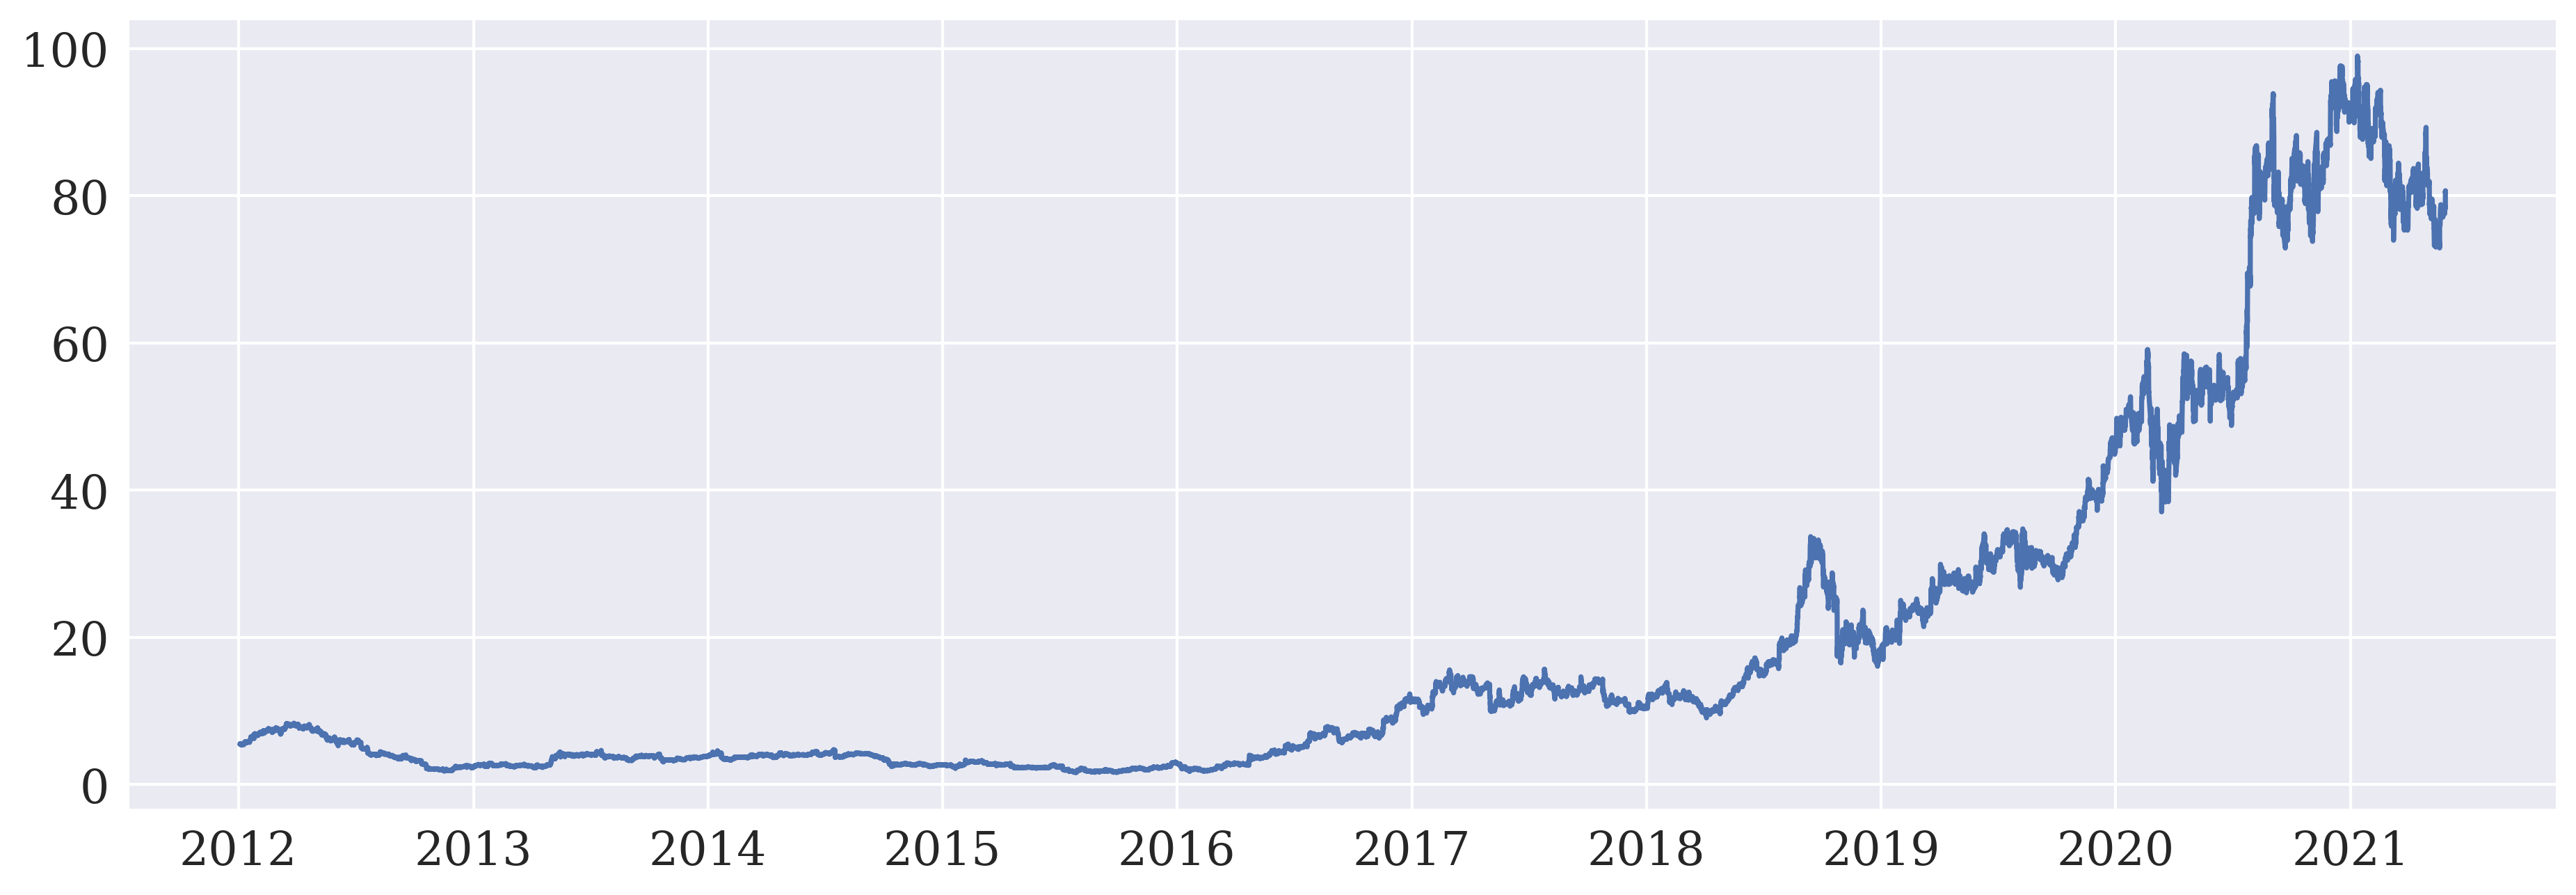

In [4]:
data_stock = get_data_by_hour("AMD")
data_stock

2012-01-03 15:00:00          NaN
2012-01-03 16:00:00          NaN
2012-01-03 17:00:00          NaN
2012-01-03 18:00:00          NaN
2012-01-03 19:00:00          NaN
                         ...    
2021-05-28 16:00:00    78.146966
2021-05-28 17:00:00    78.198166
2021-05-28 18:00:00    78.251968
2021-05-28 19:00:00    78.311568
2021-05-28 20:00:00    78.348098
Length: 33179, dtype: float64


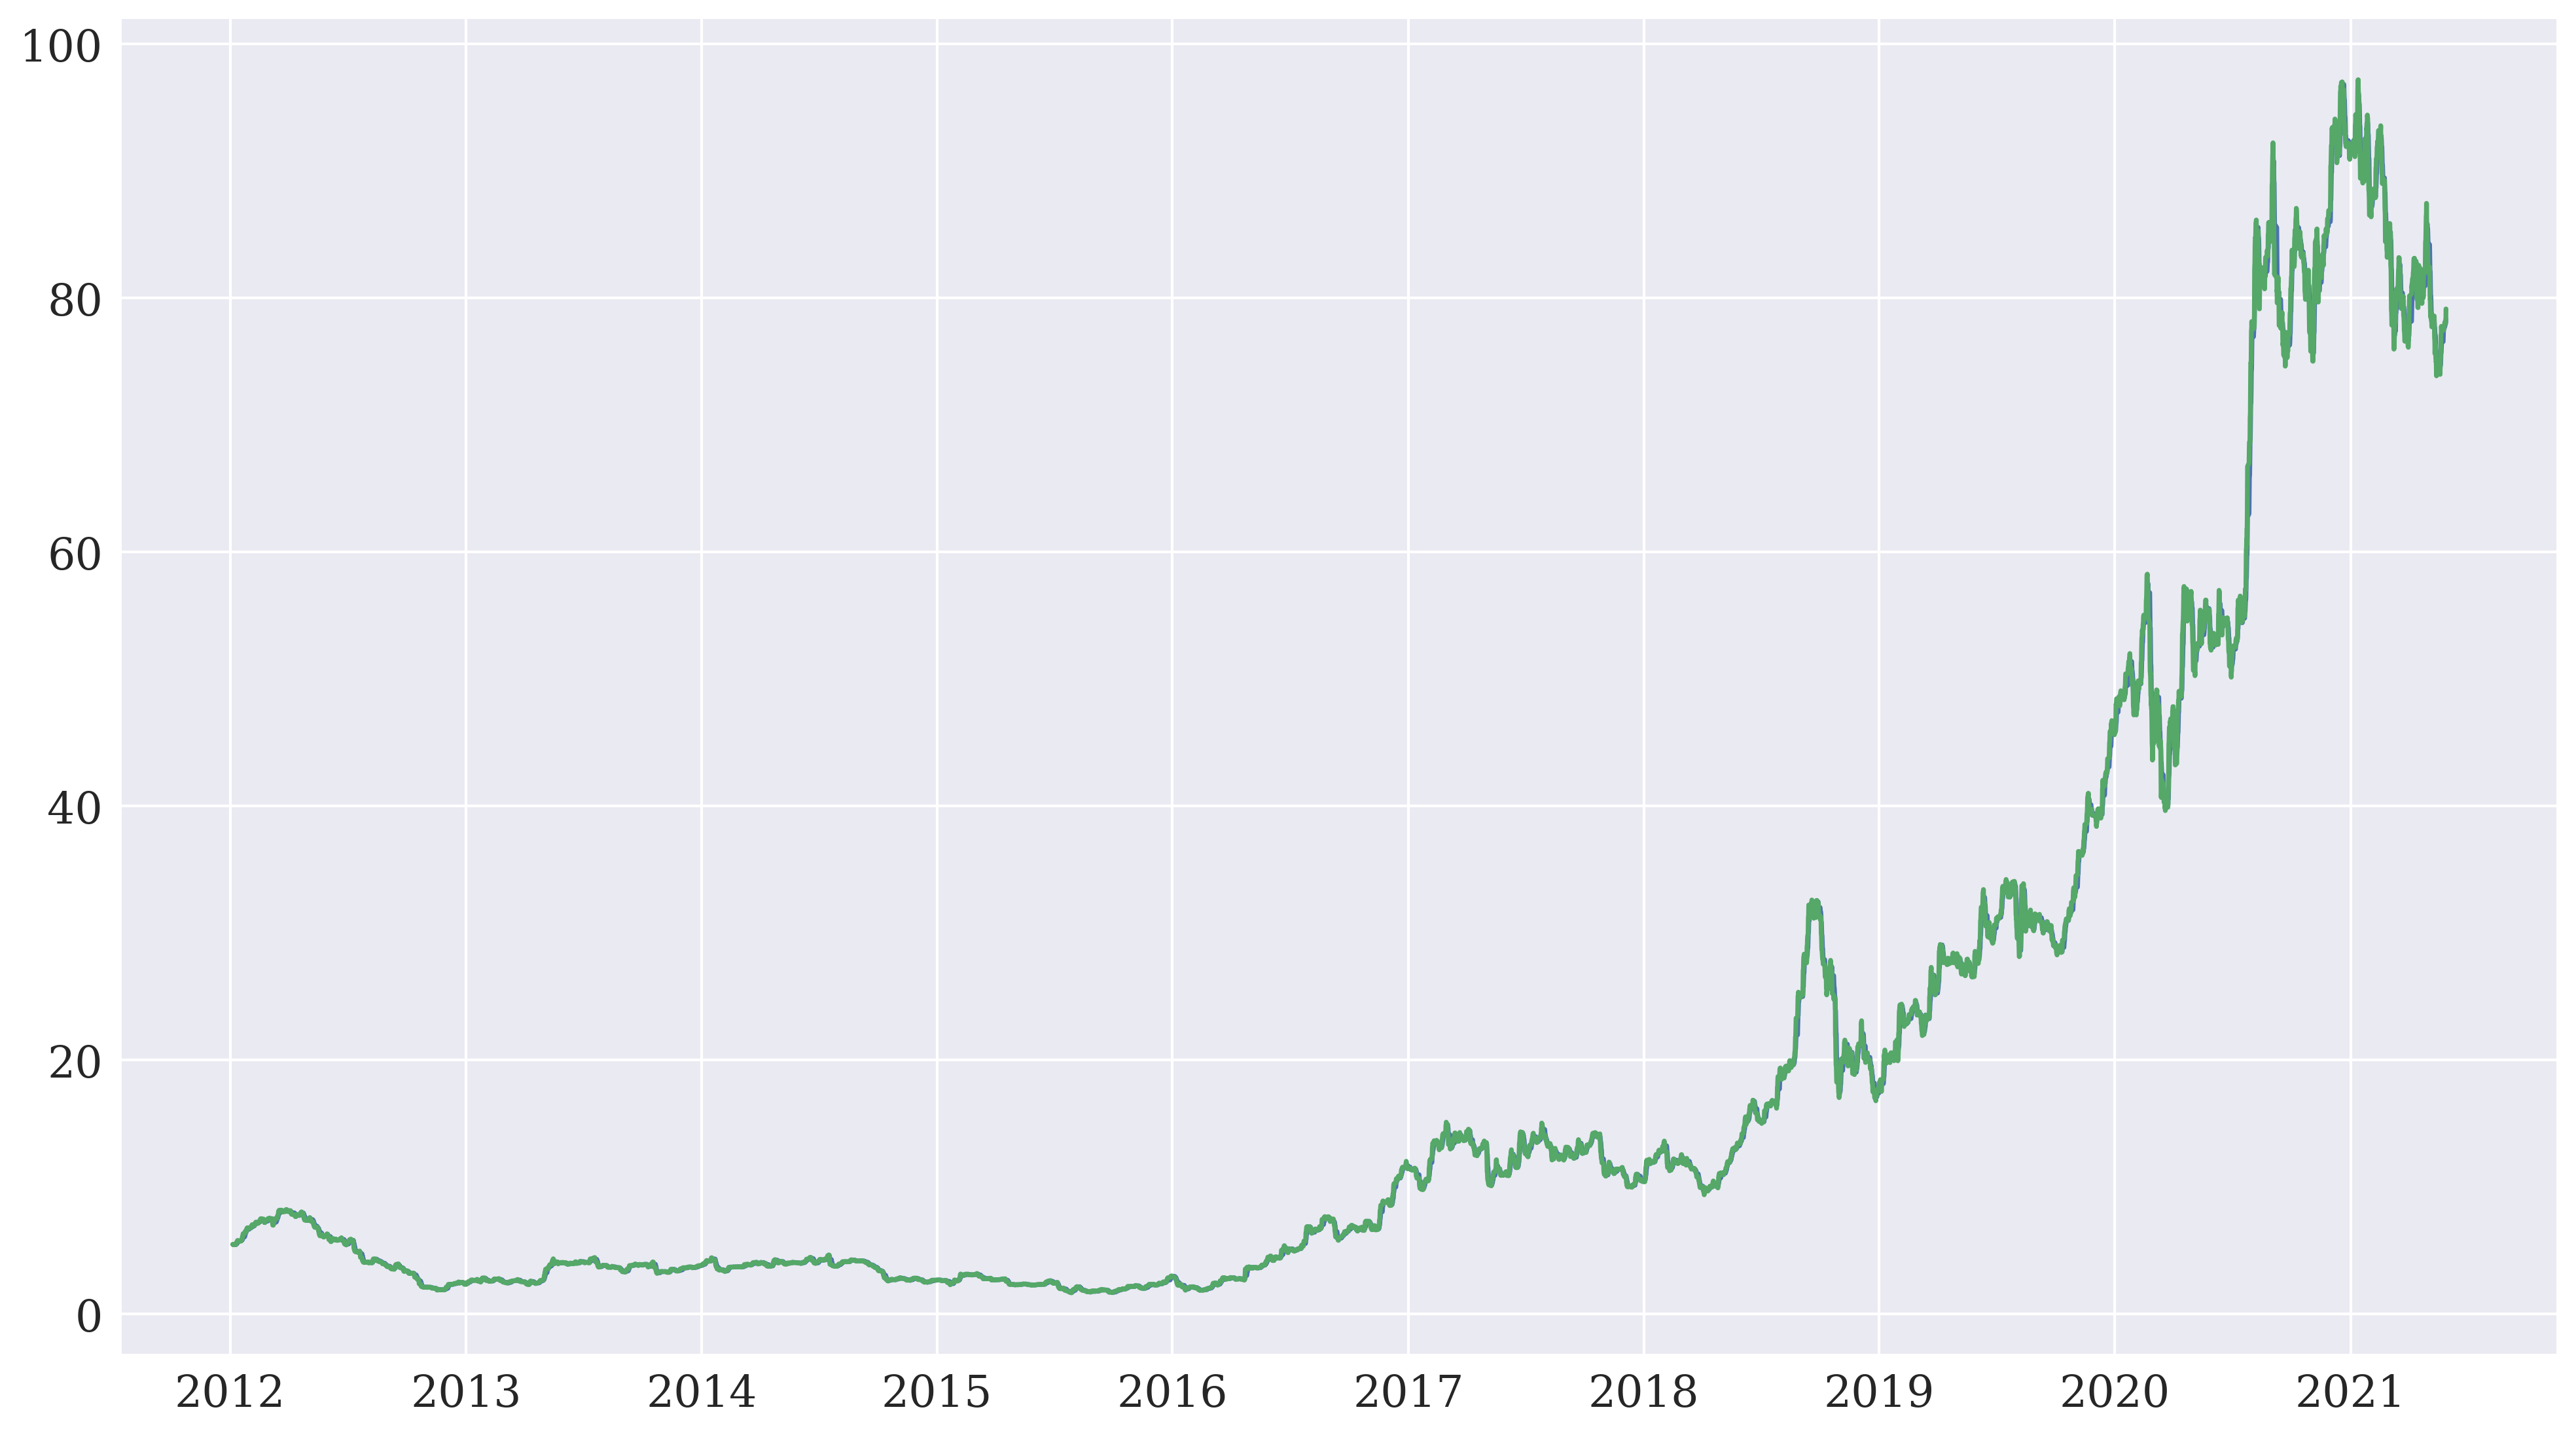

In [5]:
sma = talib.SMA(data_stock['close'], timeperiod=50)
print(sma)

fig,ax = plt.subplots()

ax.plot(sma)


ema = talib.EMA(data_stock['close'], timeperiod=20)

ax.plot(ema)



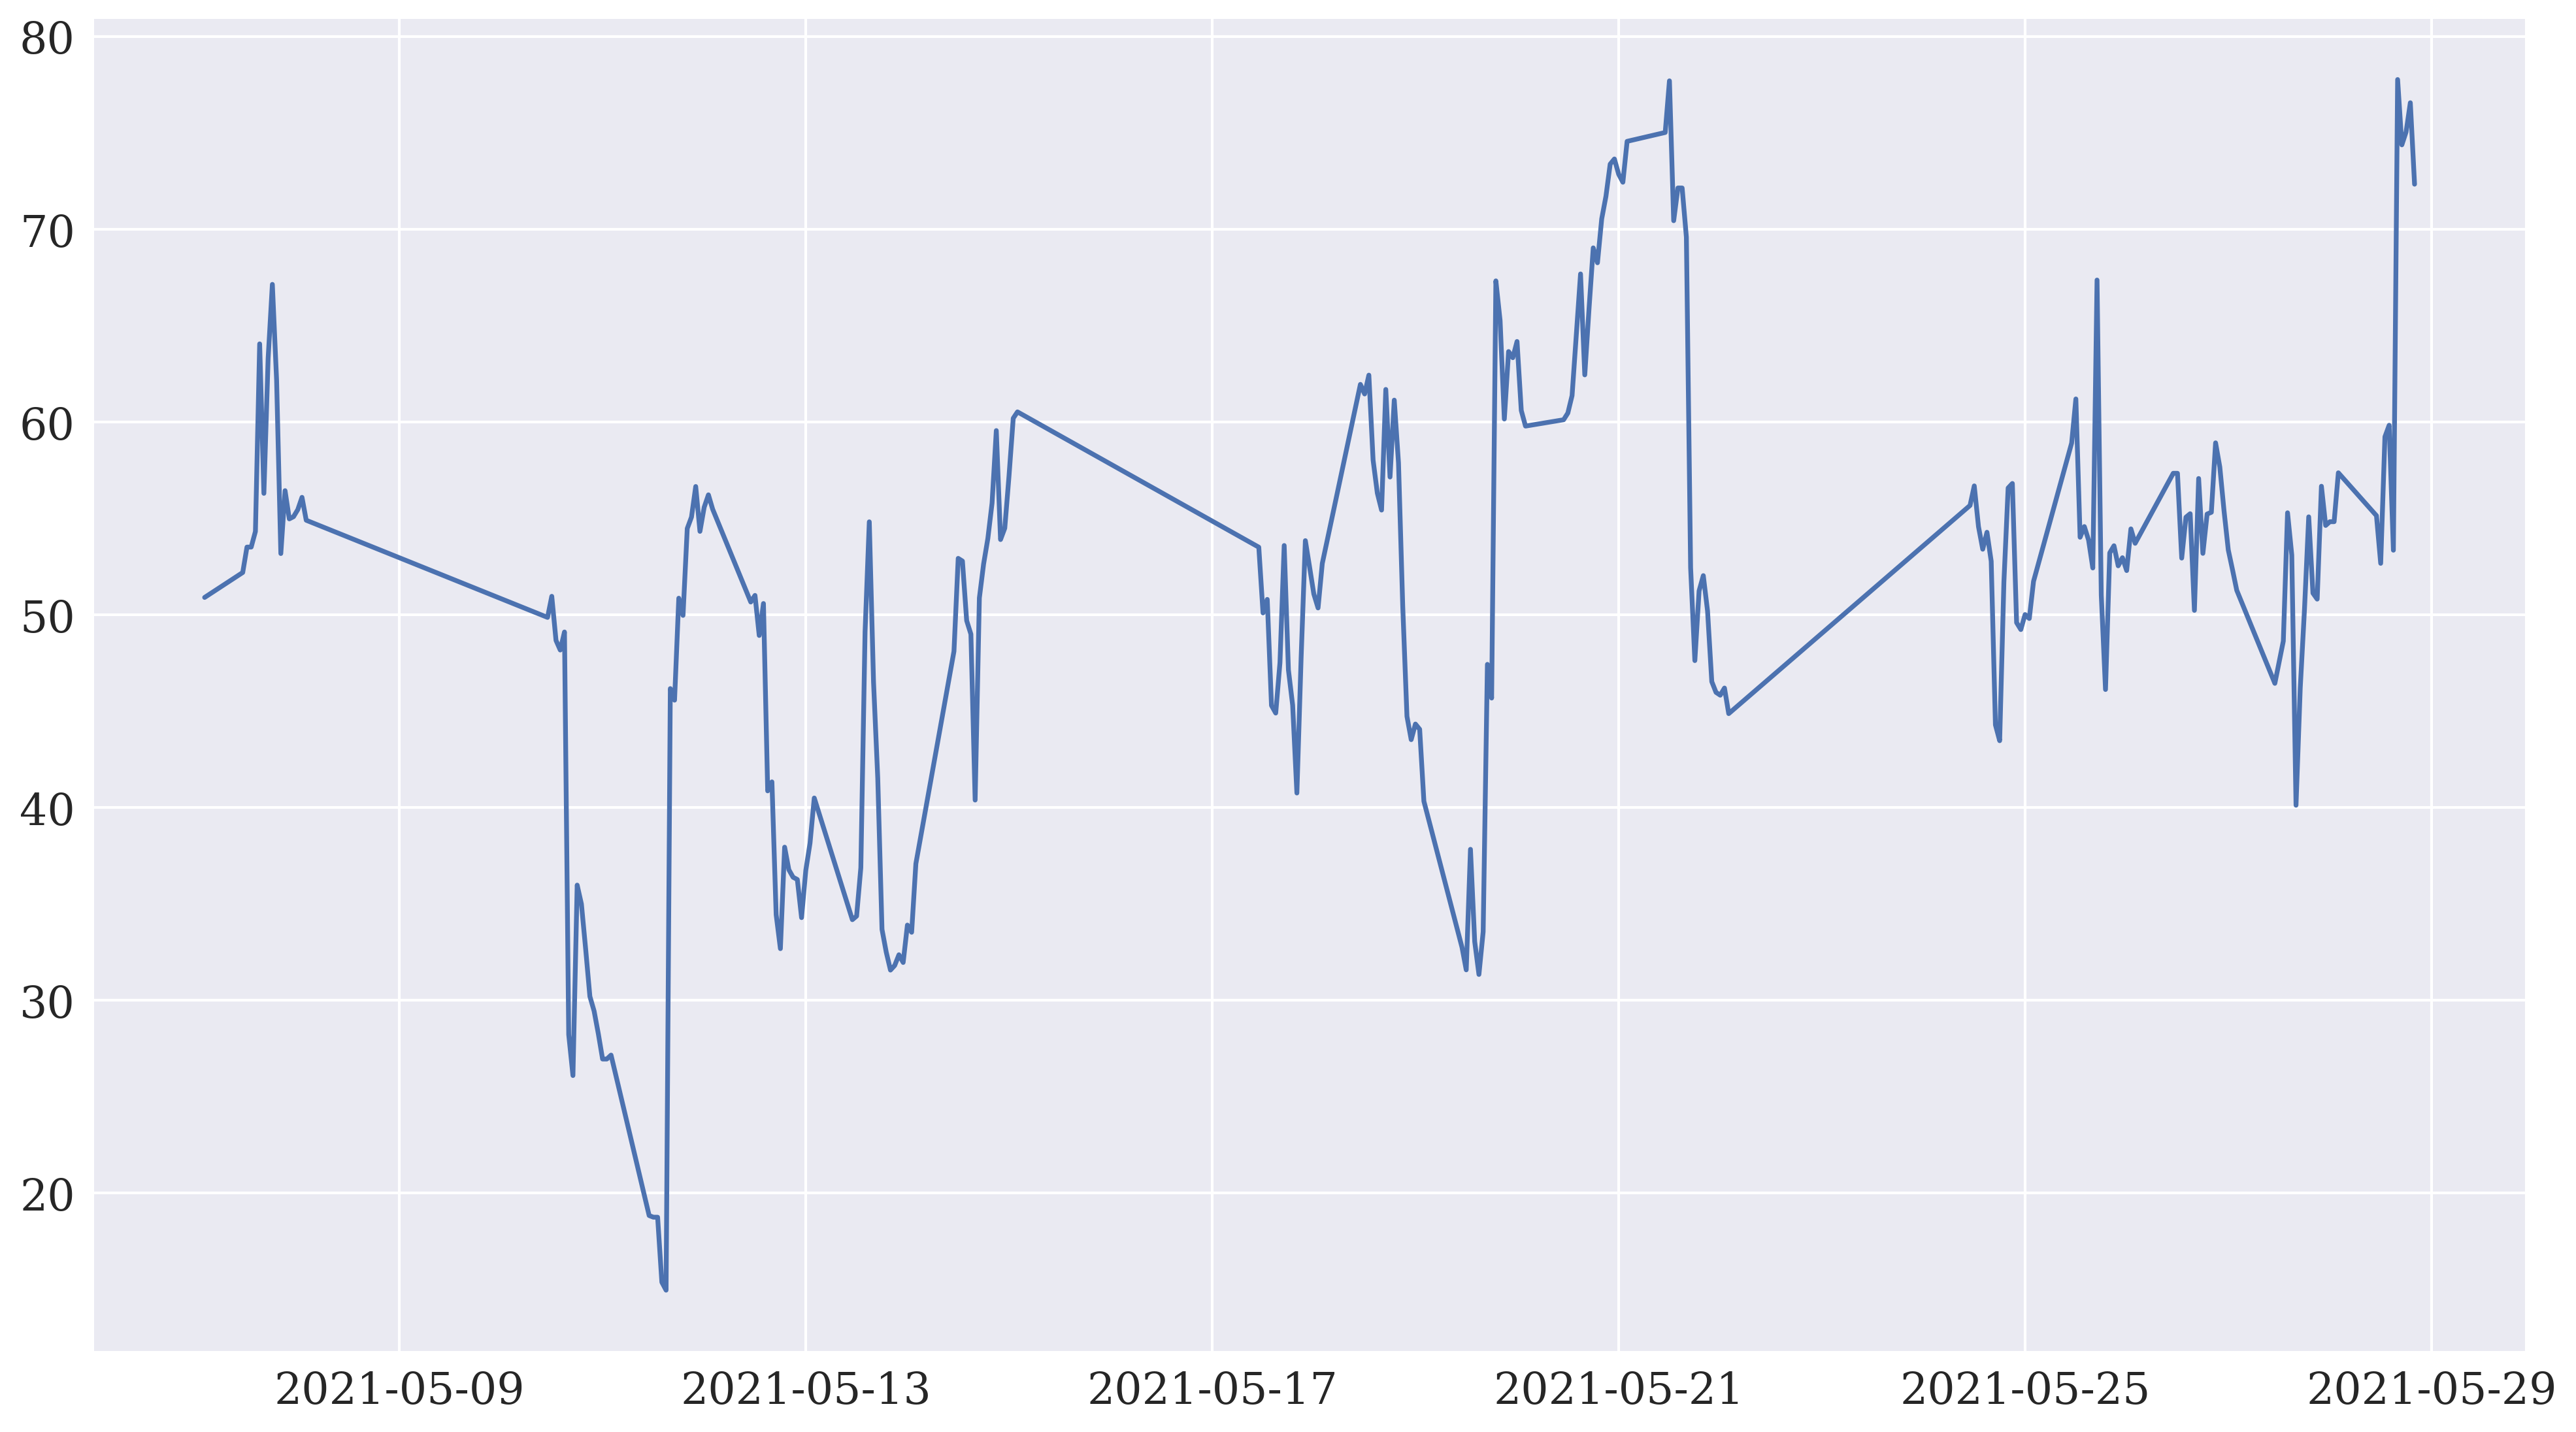

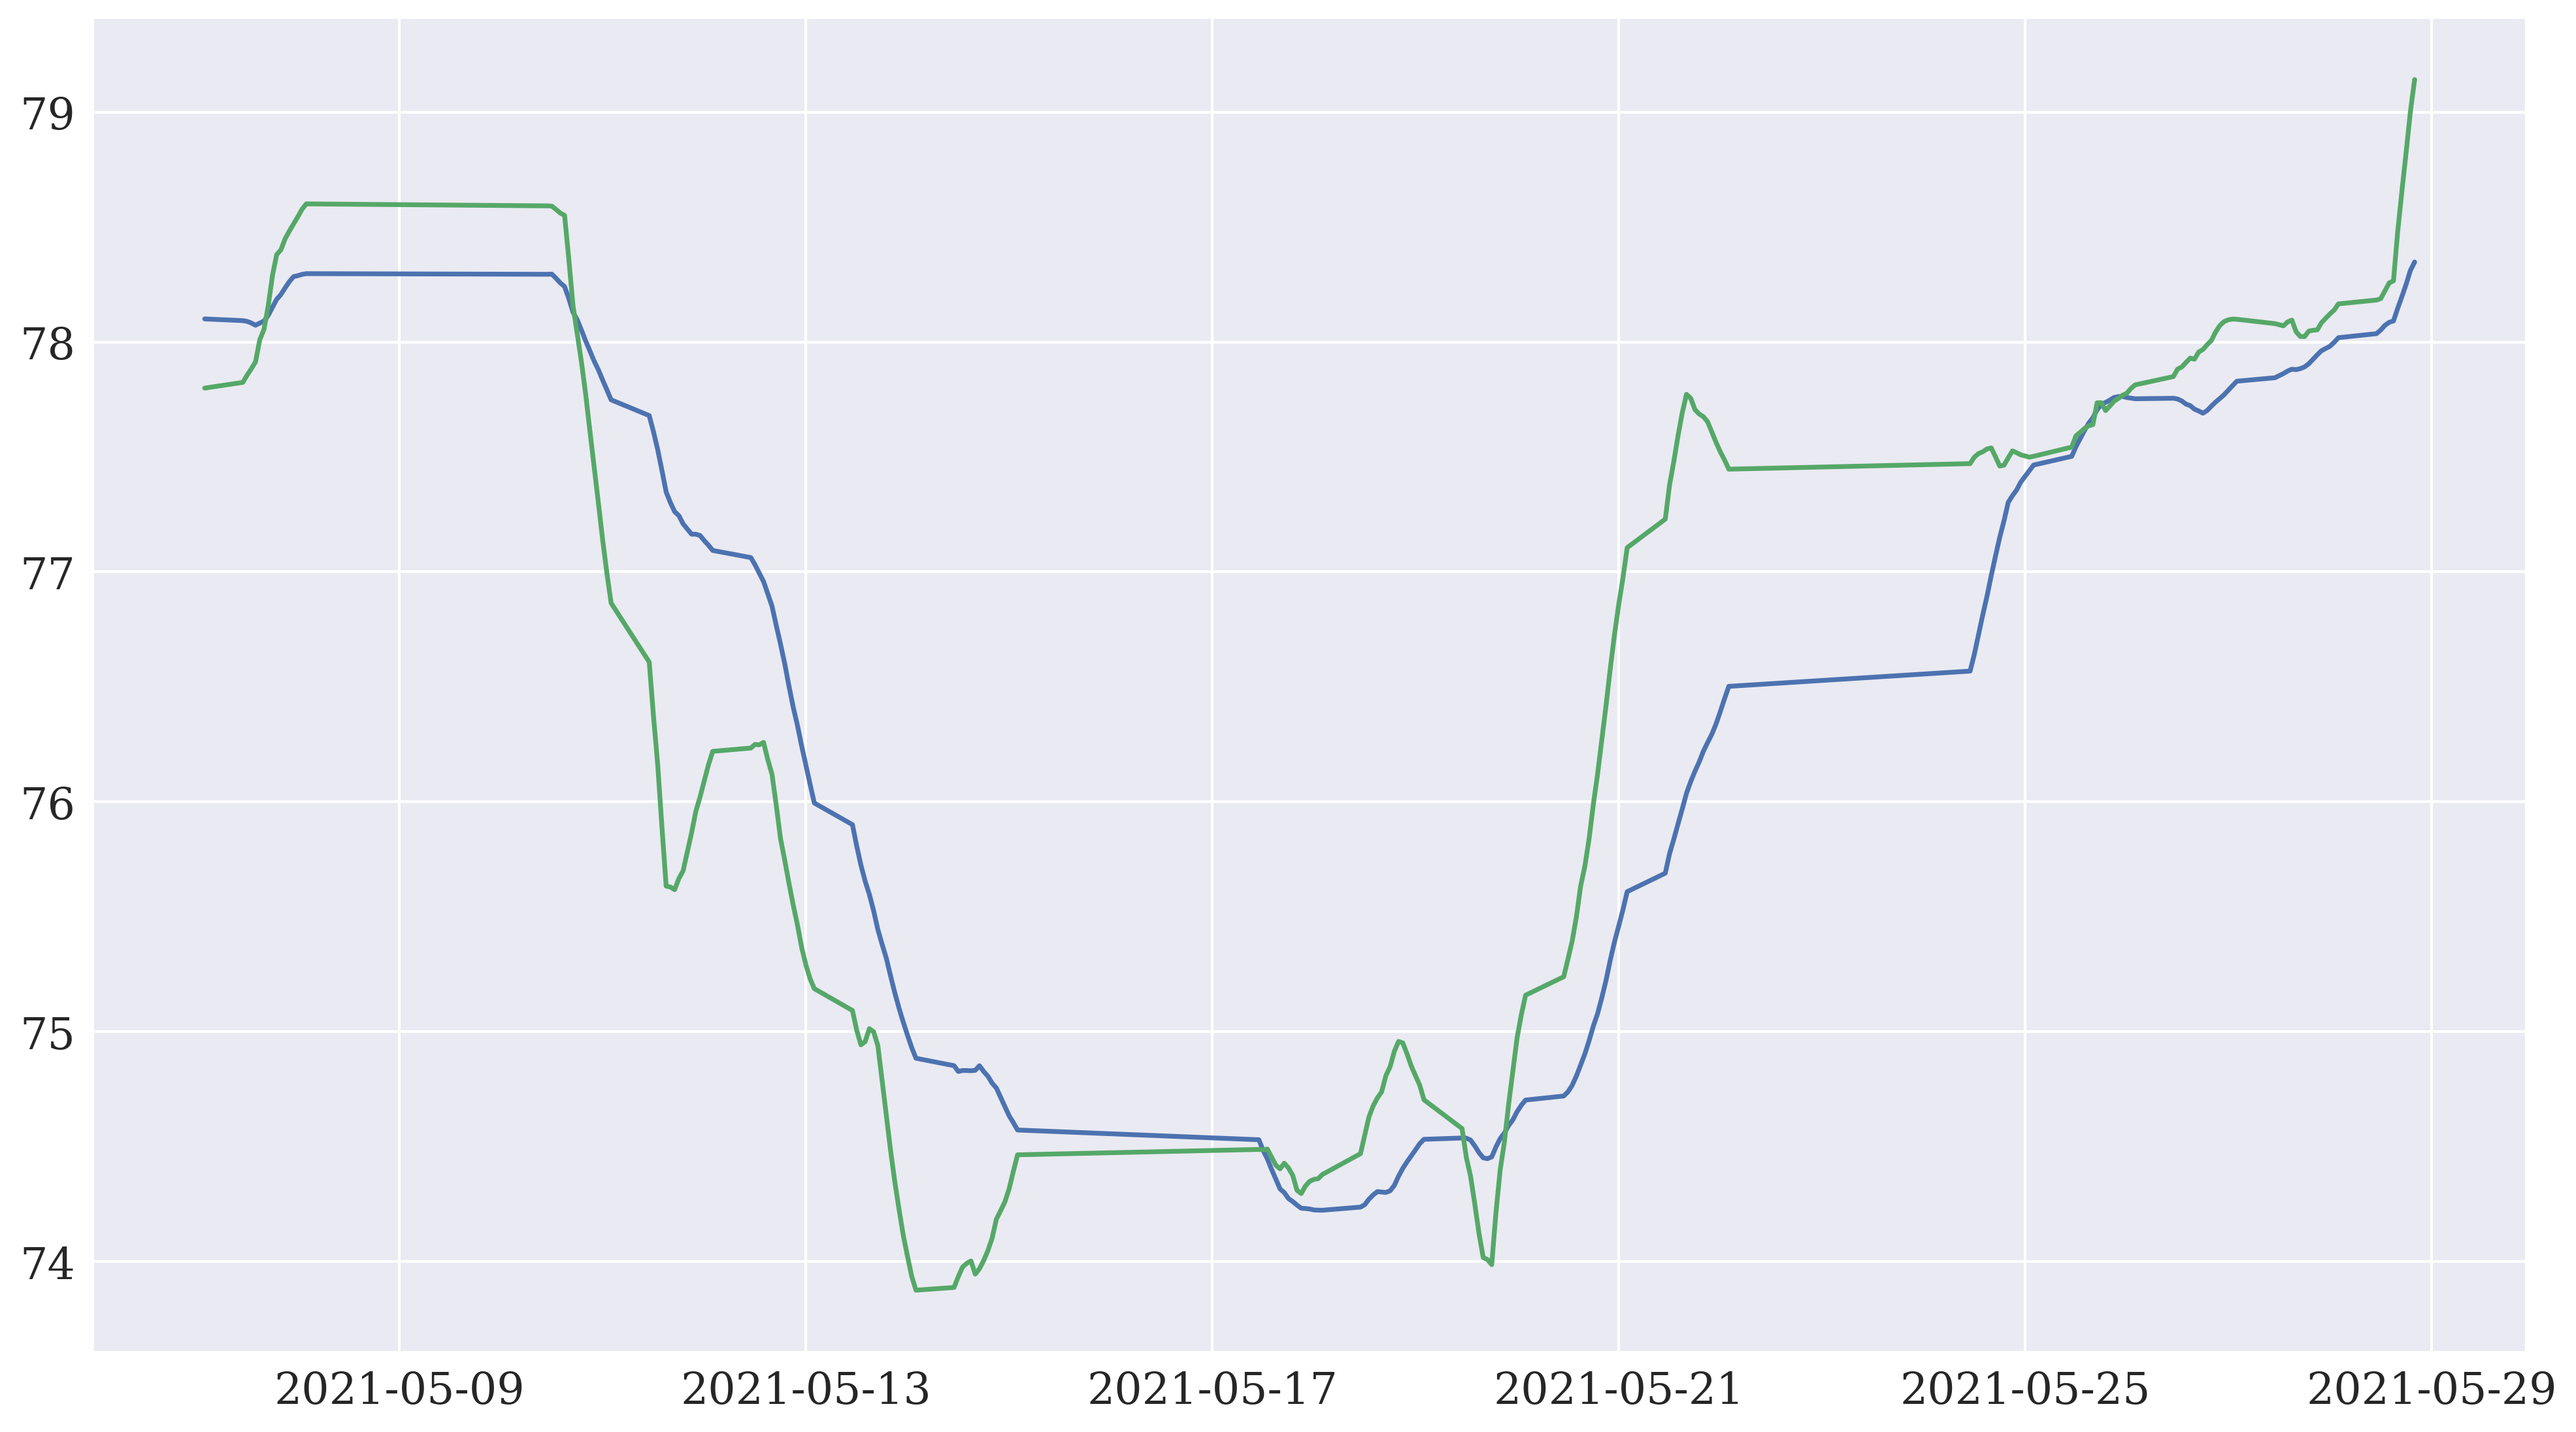

In [6]:
rsi = talib.RSI(data_stock['close'])
rsi

fig,ax = plt.subplots()

ax.plot(rsi[-250:])

fig,ax = plt.subplots()

ax.plot(sma[-250:])
ax.plot(ema[-250:])


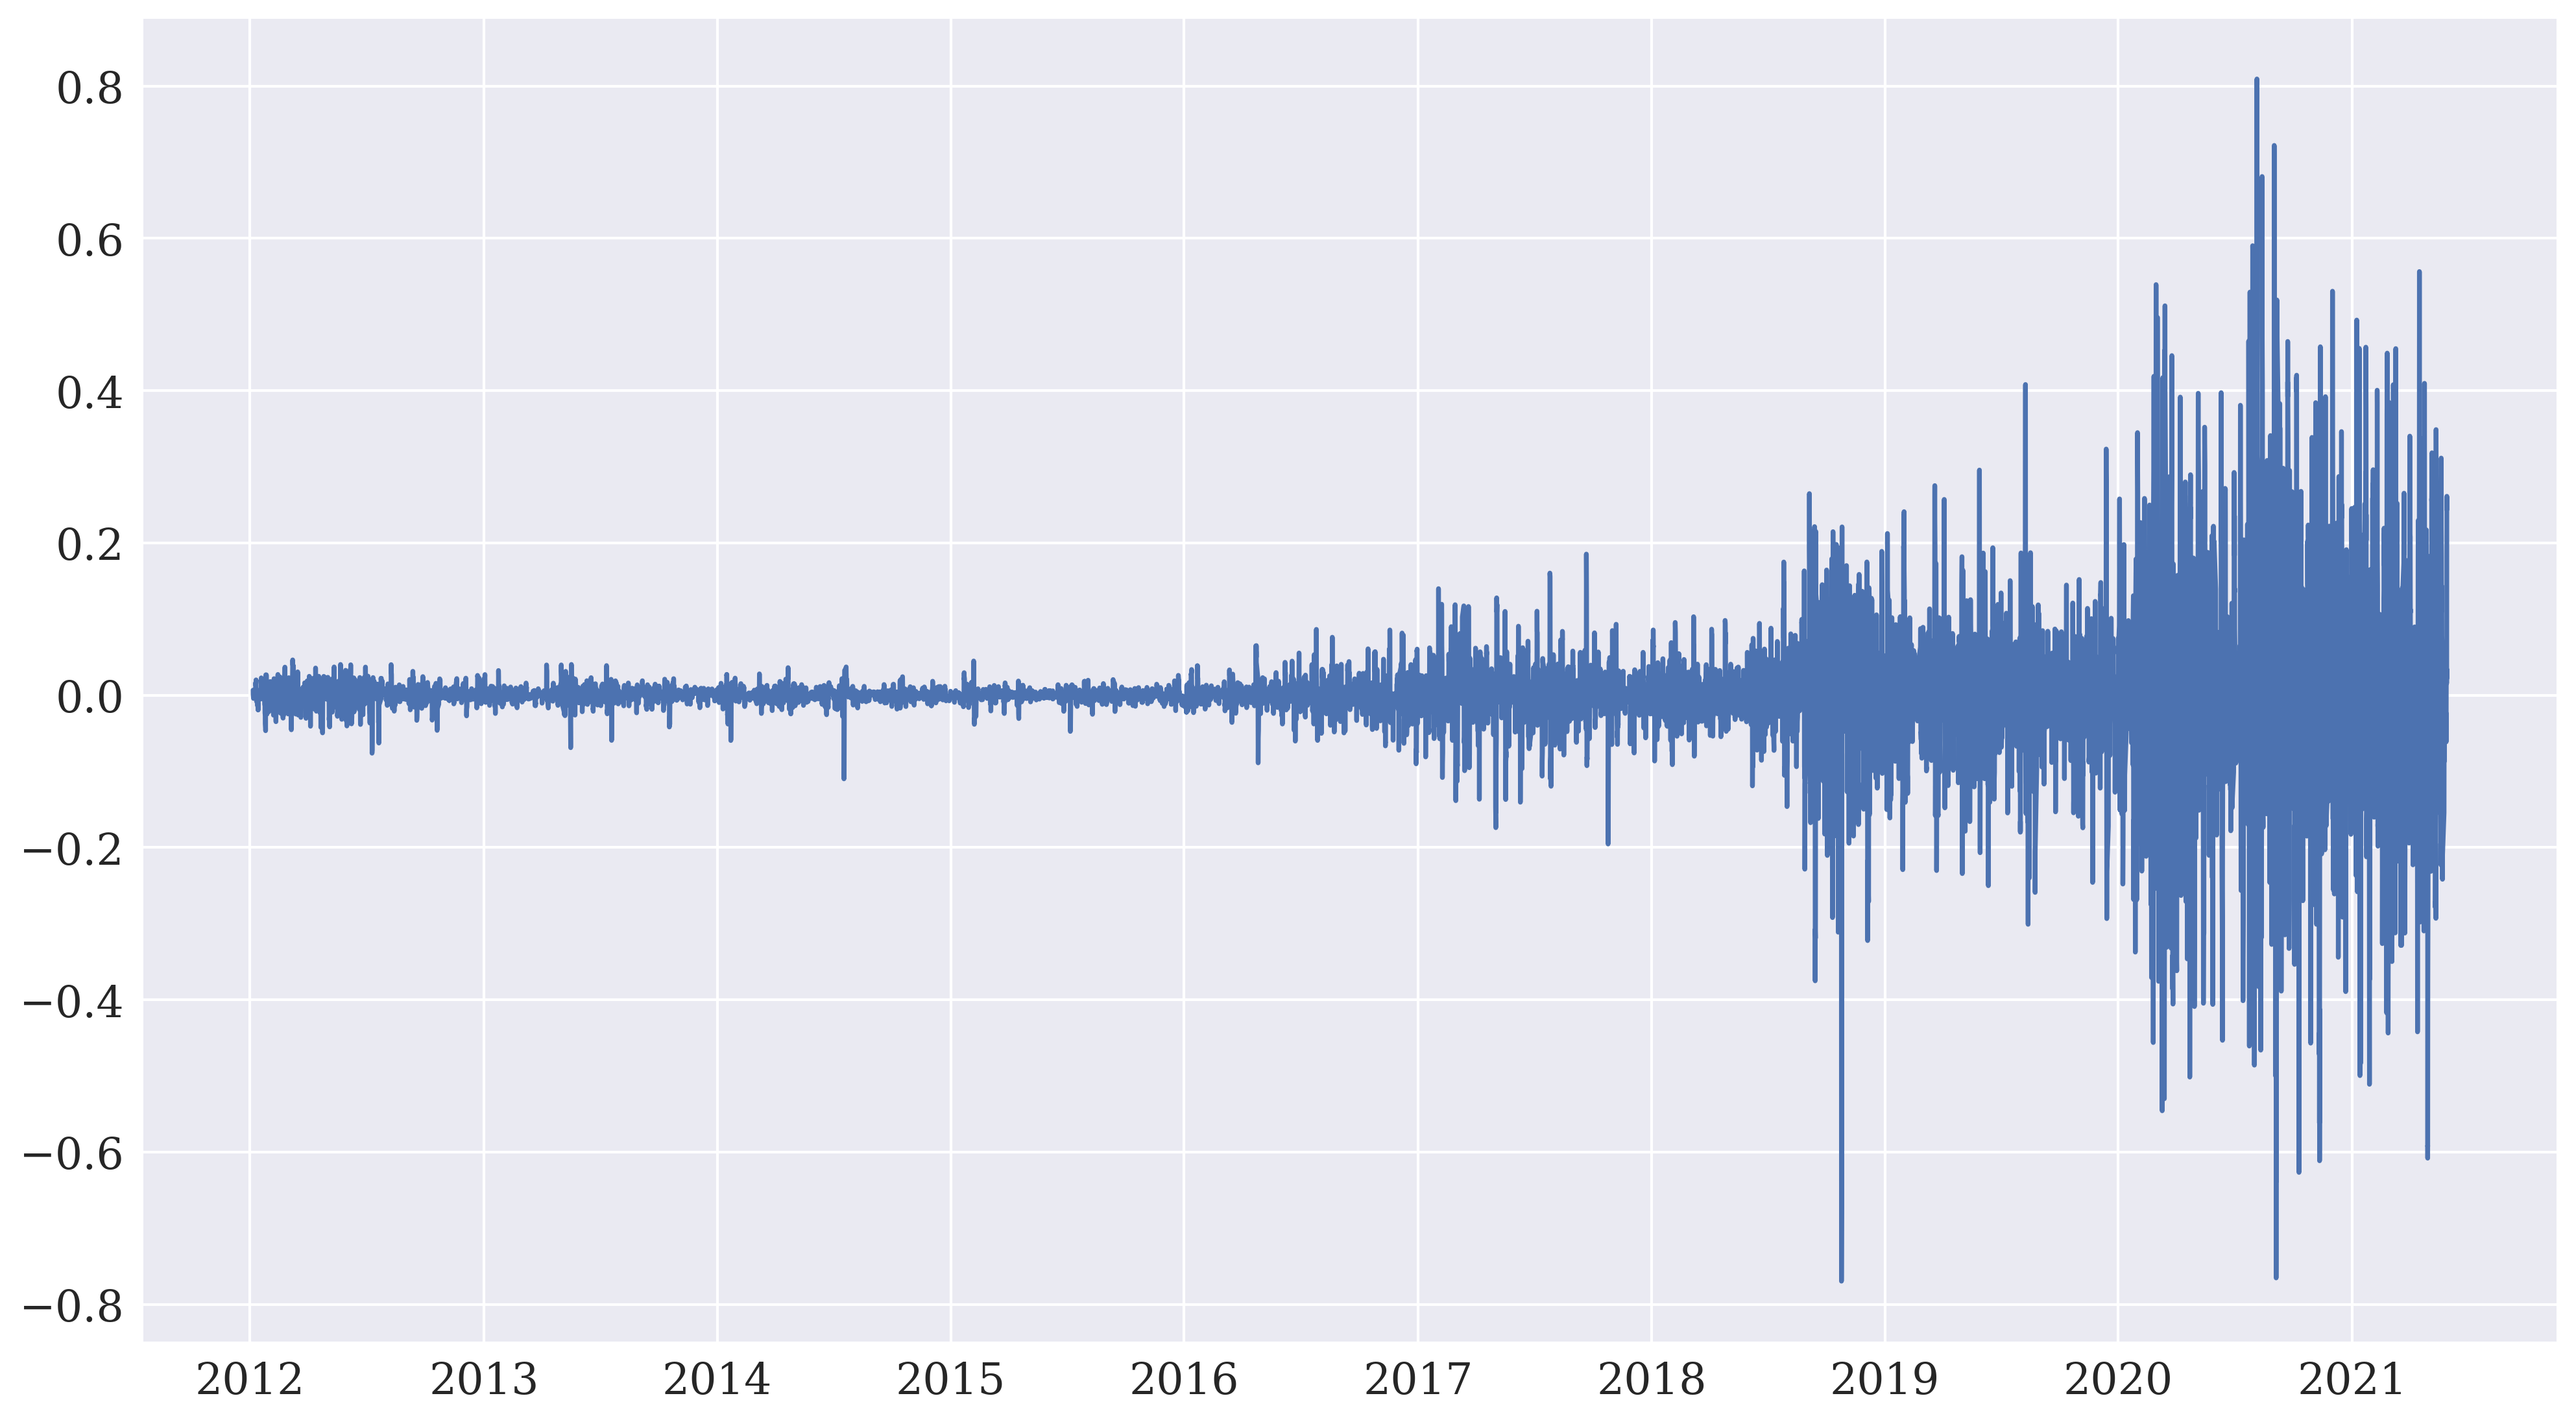

In [7]:
macd, macdsignal, macdhist = talib.MACD(data_stock['close'], fastperiod=12, slowperiod=26, signalperiod=9)
macdhist

fig,ax = plt.subplots()

ax.plot(macdhist)

In [8]:
price = data_stock['close']


def get_Daily_Volatility(close,span0=24):
    # simple percentage returns
    df0=close.pct_change()
    # 20 days, a month EWM's std as boundary
    df0=df0.ewm(span=span0).std()
    df0.dropna(inplace=True)
    return df0
df0 = get_Daily_Volatility(price)

#set the boundary of barriers, based on 20 days EWM
daily_volatility = get_Daily_Volatility(price)
# how many days we hold the stock which set the vertical barrier
t_final = 10 
#the up and low boundary multipliers
upper_lower_multipliers = [3, 2]
#allign the index
prices = price[daily_volatility.index]

def get_3_barriers():
    #create a container
    barriers = pd.DataFrame(columns=['days_passed', 'price', 'vert_barrier', 'top_barrier', 'bottom_barrier'], index = daily_volatility.index)
    for day, vol in daily_volatility.iteritems():
        days_passed = len(daily_volatility.loc[daily_volatility.index[0] : day])
        #set the vertical barrier 
        if (days_passed + t_final < len(daily_volatility.index) \
            and t_final != 0):
            vert_barrier = daily_volatility.index[
                                days_passed + t_final]
        else:
            vert_barrier = np.nan
        #set the top barrier
        if upper_lower_multipliers[0] > 0:
            top_barrier = prices.loc[day] + prices.loc[day] * \
                          upper_lower_multipliers[0] * vol
        else:
            #set it to NaNs
            top_barrier = pd.Series(index=prices.index)
        #set the bottom barrier
        if upper_lower_multipliers[1] > 0:
            bottom_barrier = prices.loc[day] - prices.loc[day] * \
                          upper_lower_multipliers[1] * vol
        else: 
            #set it to NaNs
            bottom_barrier = pd.Series(index=prices.index)
        barriers.loc[day, ['days_passed', 'price', \
        'vert_barrier','top_barrier', 'bottom_barrier']] = \
         days_passed, prices.loc[day], vert_barrier, \
         top_barrier, bottom_barrier
    barriers['out'] = None
    return barriers


barriers = get_3_barriers()

def get_labels():
    for i in range(len(barriers.index)):
        start = barriers.index[i]
        end = barriers.vert_barrier[i]
        if pd.notna(end):
                # assign the initial and final price
                price_initial = barriers.price[start]
                price_final = barriers.price[end]
    # assign the top and bottom barriers
                top_barrier = barriers.top_barrier[i]
                bottom_barrier = barriers.bottom_barrier[i]
    #set the profit taking and stop loss conditons
                condition_pt = (barriers.price[start: end] >= \
                 top_barrier).any()
                condition_sl = (barriers.price[start: end] <= \
                 bottom_barrier).any()
    #assign the labels
                if condition_pt: 
                    barriers['out'][i] = 1
                elif condition_sl: 
                    barriers['out'][i] = -1    
                else: 
                    barriers['out'][i] = 0
    return

get_labels()

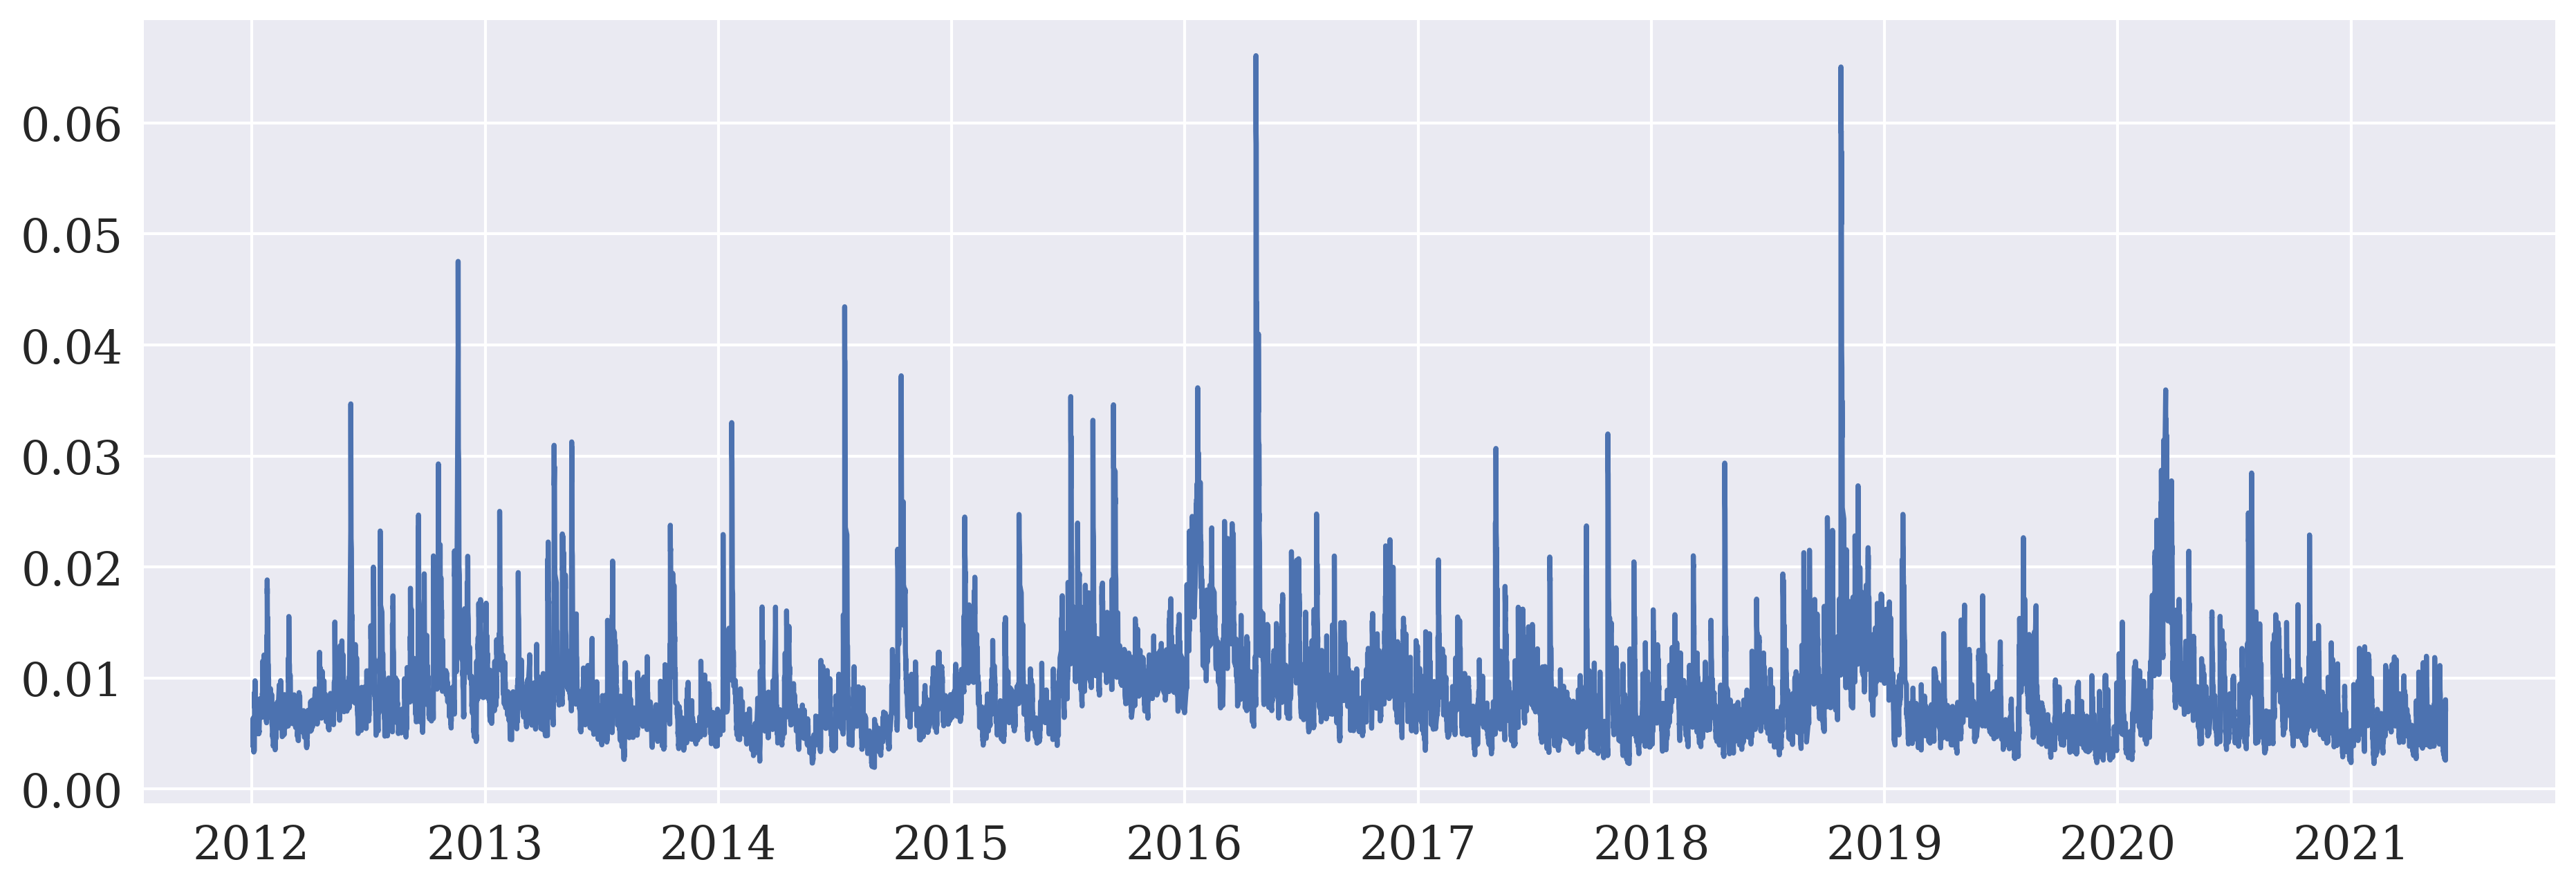

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(df0.index, df0.values)
plt.grid(True)

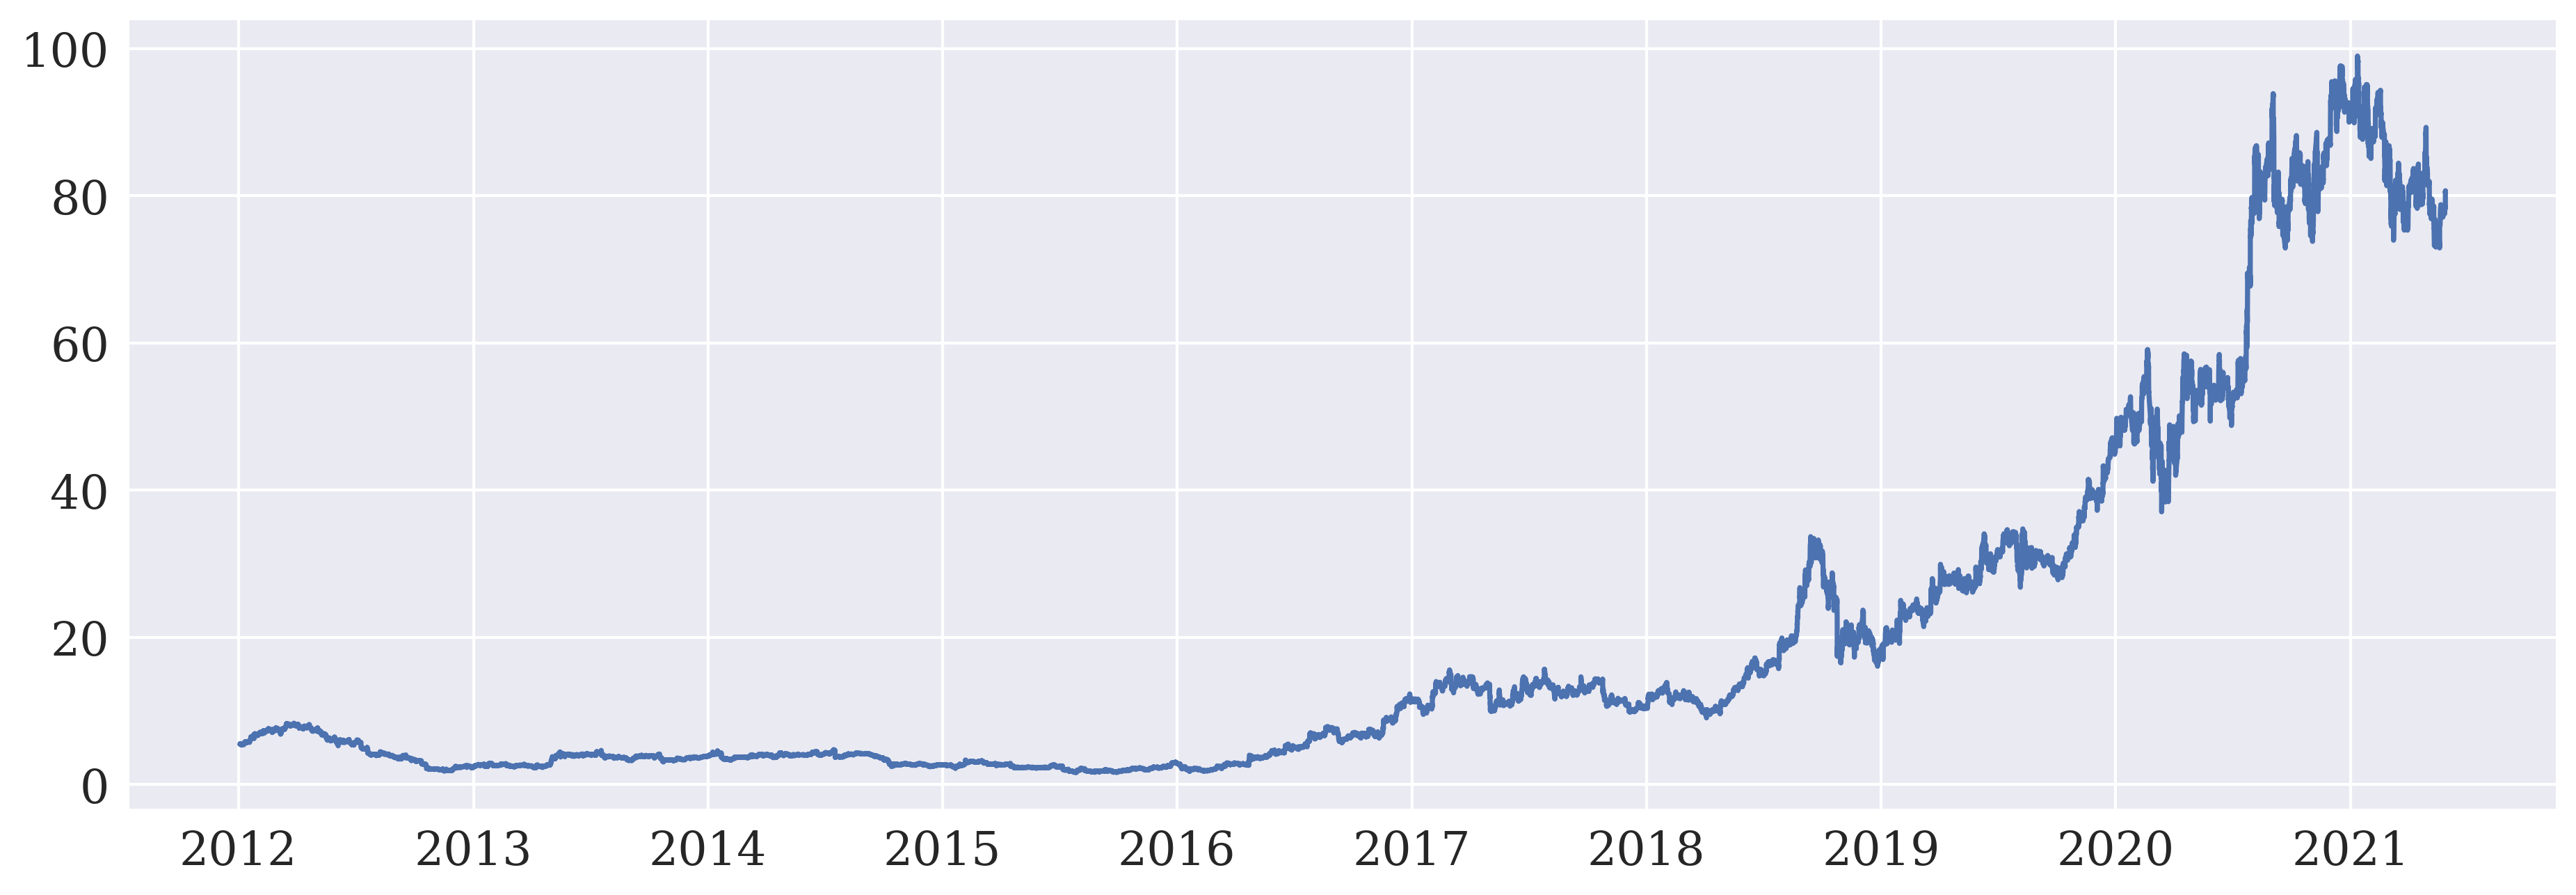

In [10]:
plt.figure(figsize=(15, 5))
plt.plot(data_stock.index, data_stock['close'].values)
plt.grid(True)

In [11]:
counts = barriers.out.value_counts()
counts

 0    13541
-1    11297
 1     8328
Name: out, dtype: int64

In [12]:
counts.sum()

33166

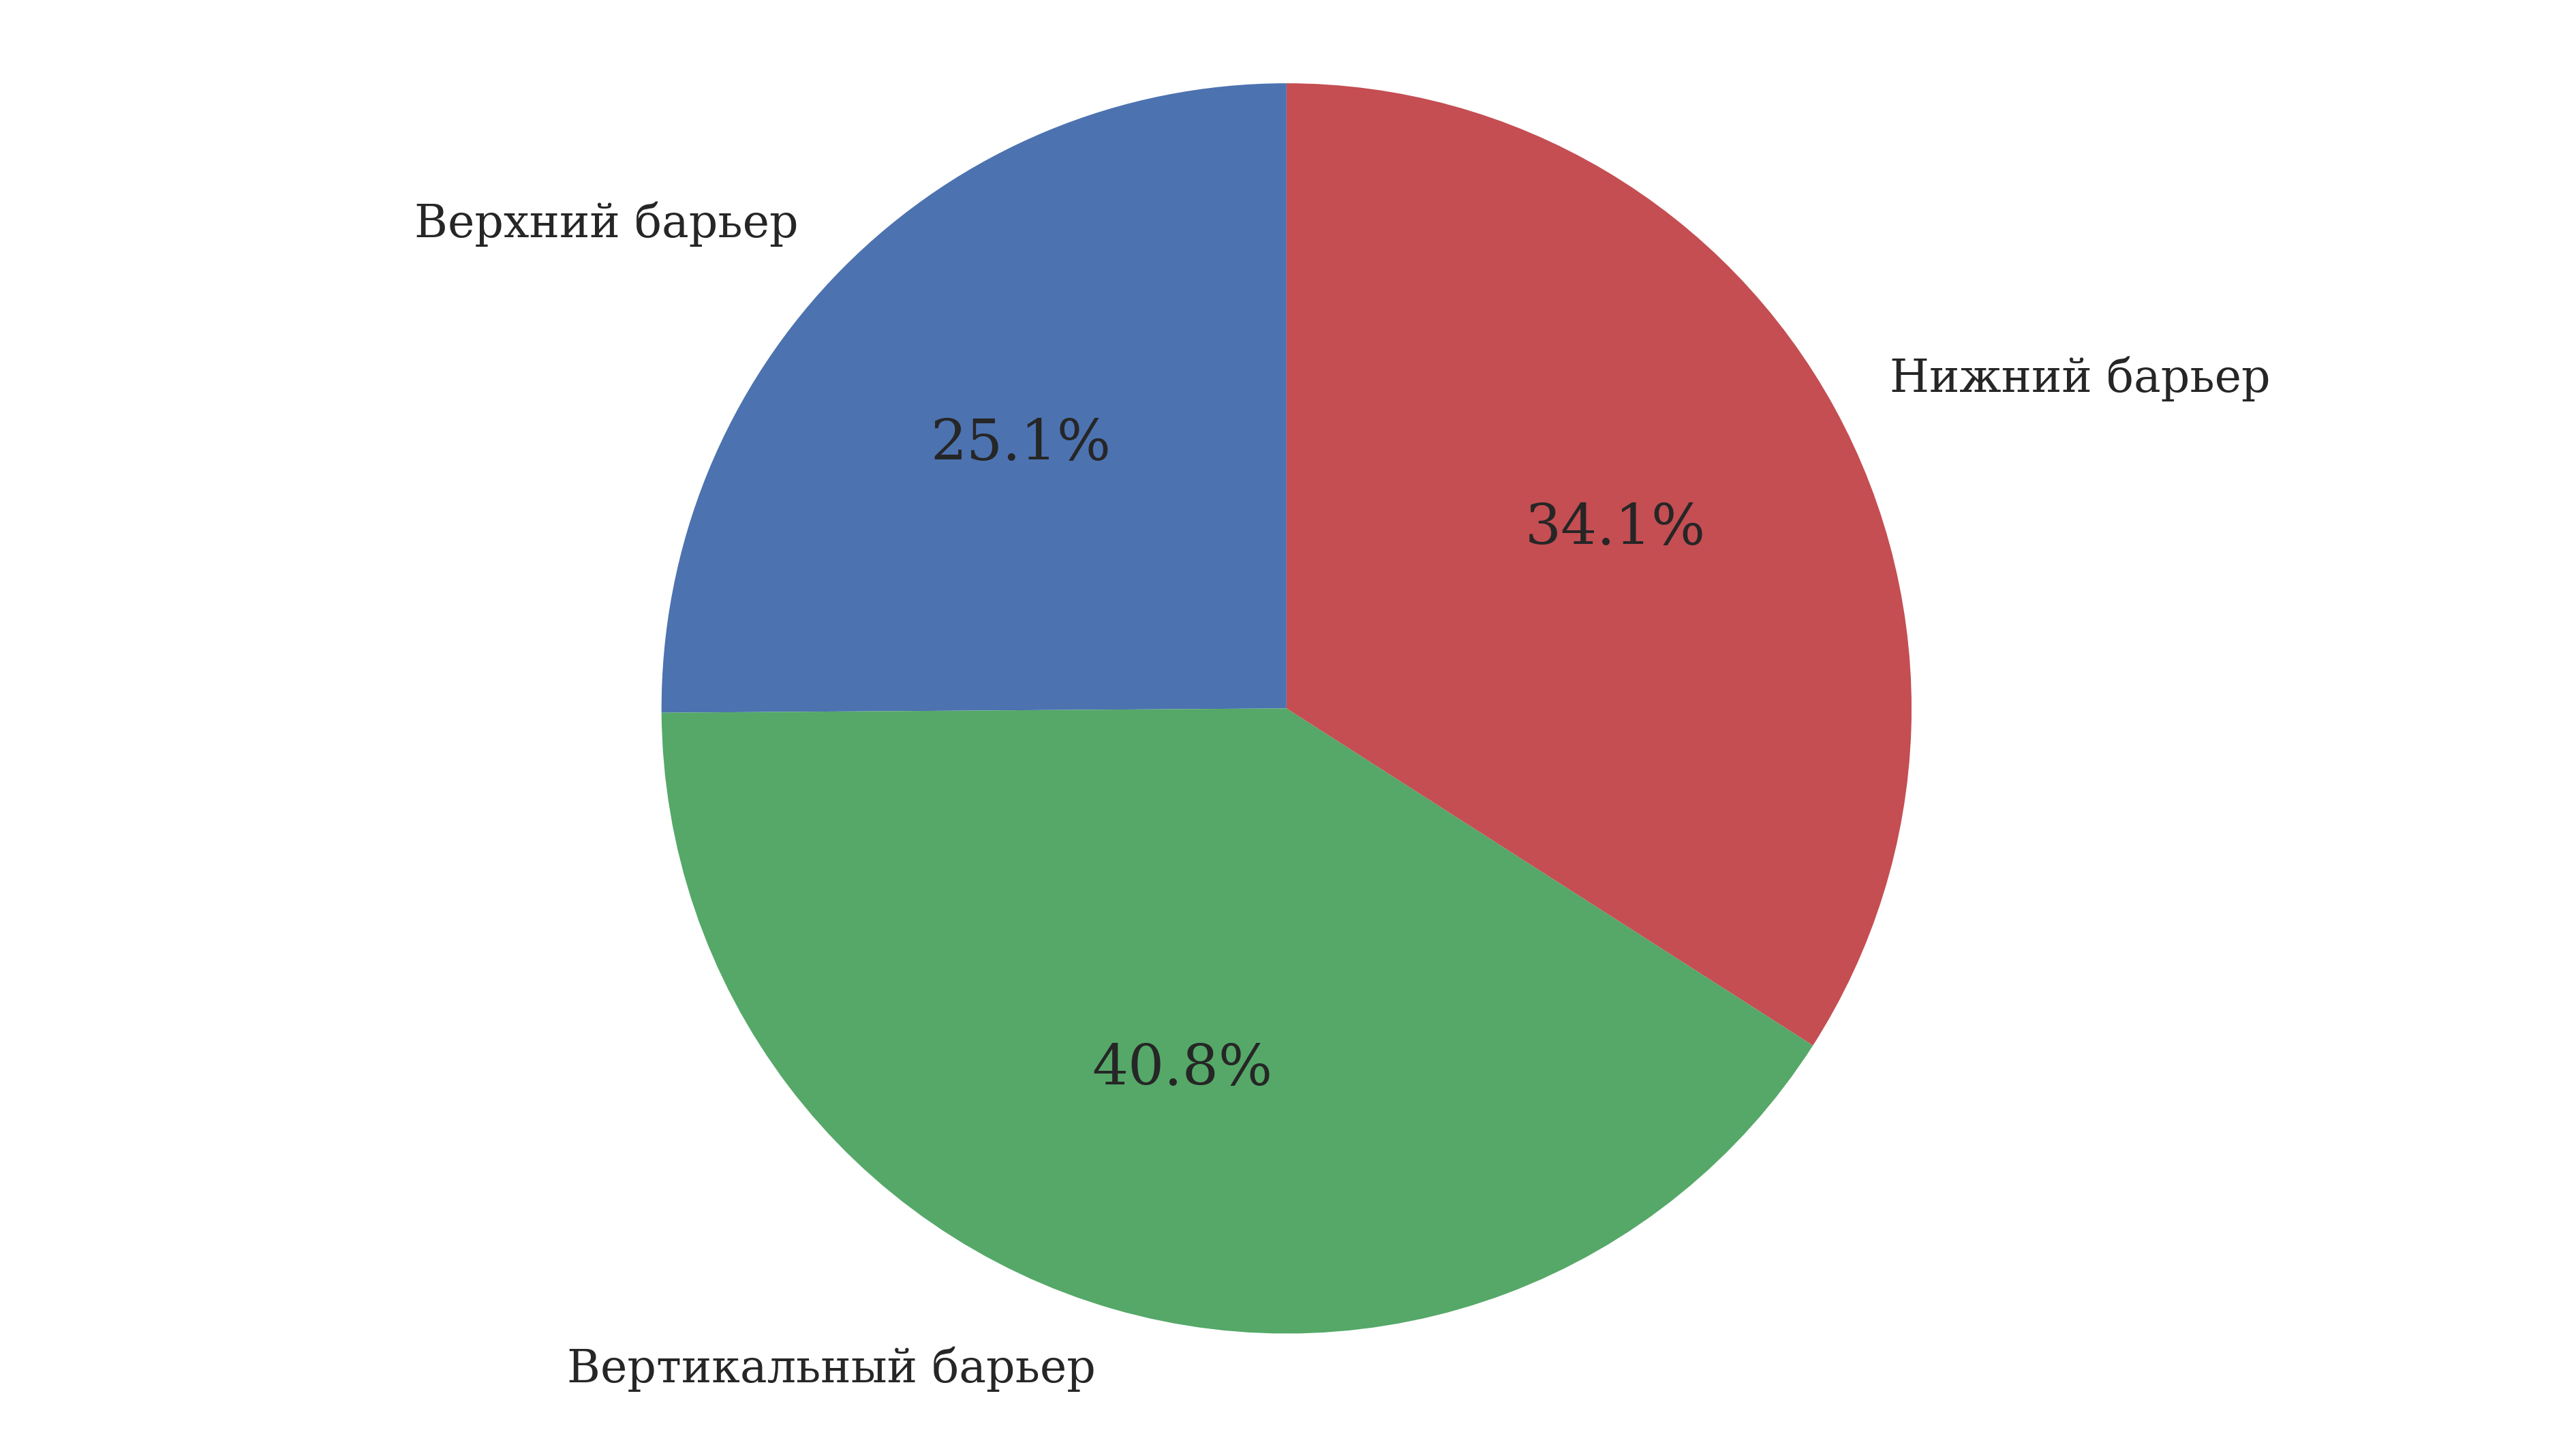

In [13]:
labels = 'Верхний барьер', 'Вертикальный барьер', 'Нижний барьер'
sizes = [(counts[1]*100)/counts.sum(), (counts[0]*100)/counts.sum(), (counts[-1]*100)/counts.sum()]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

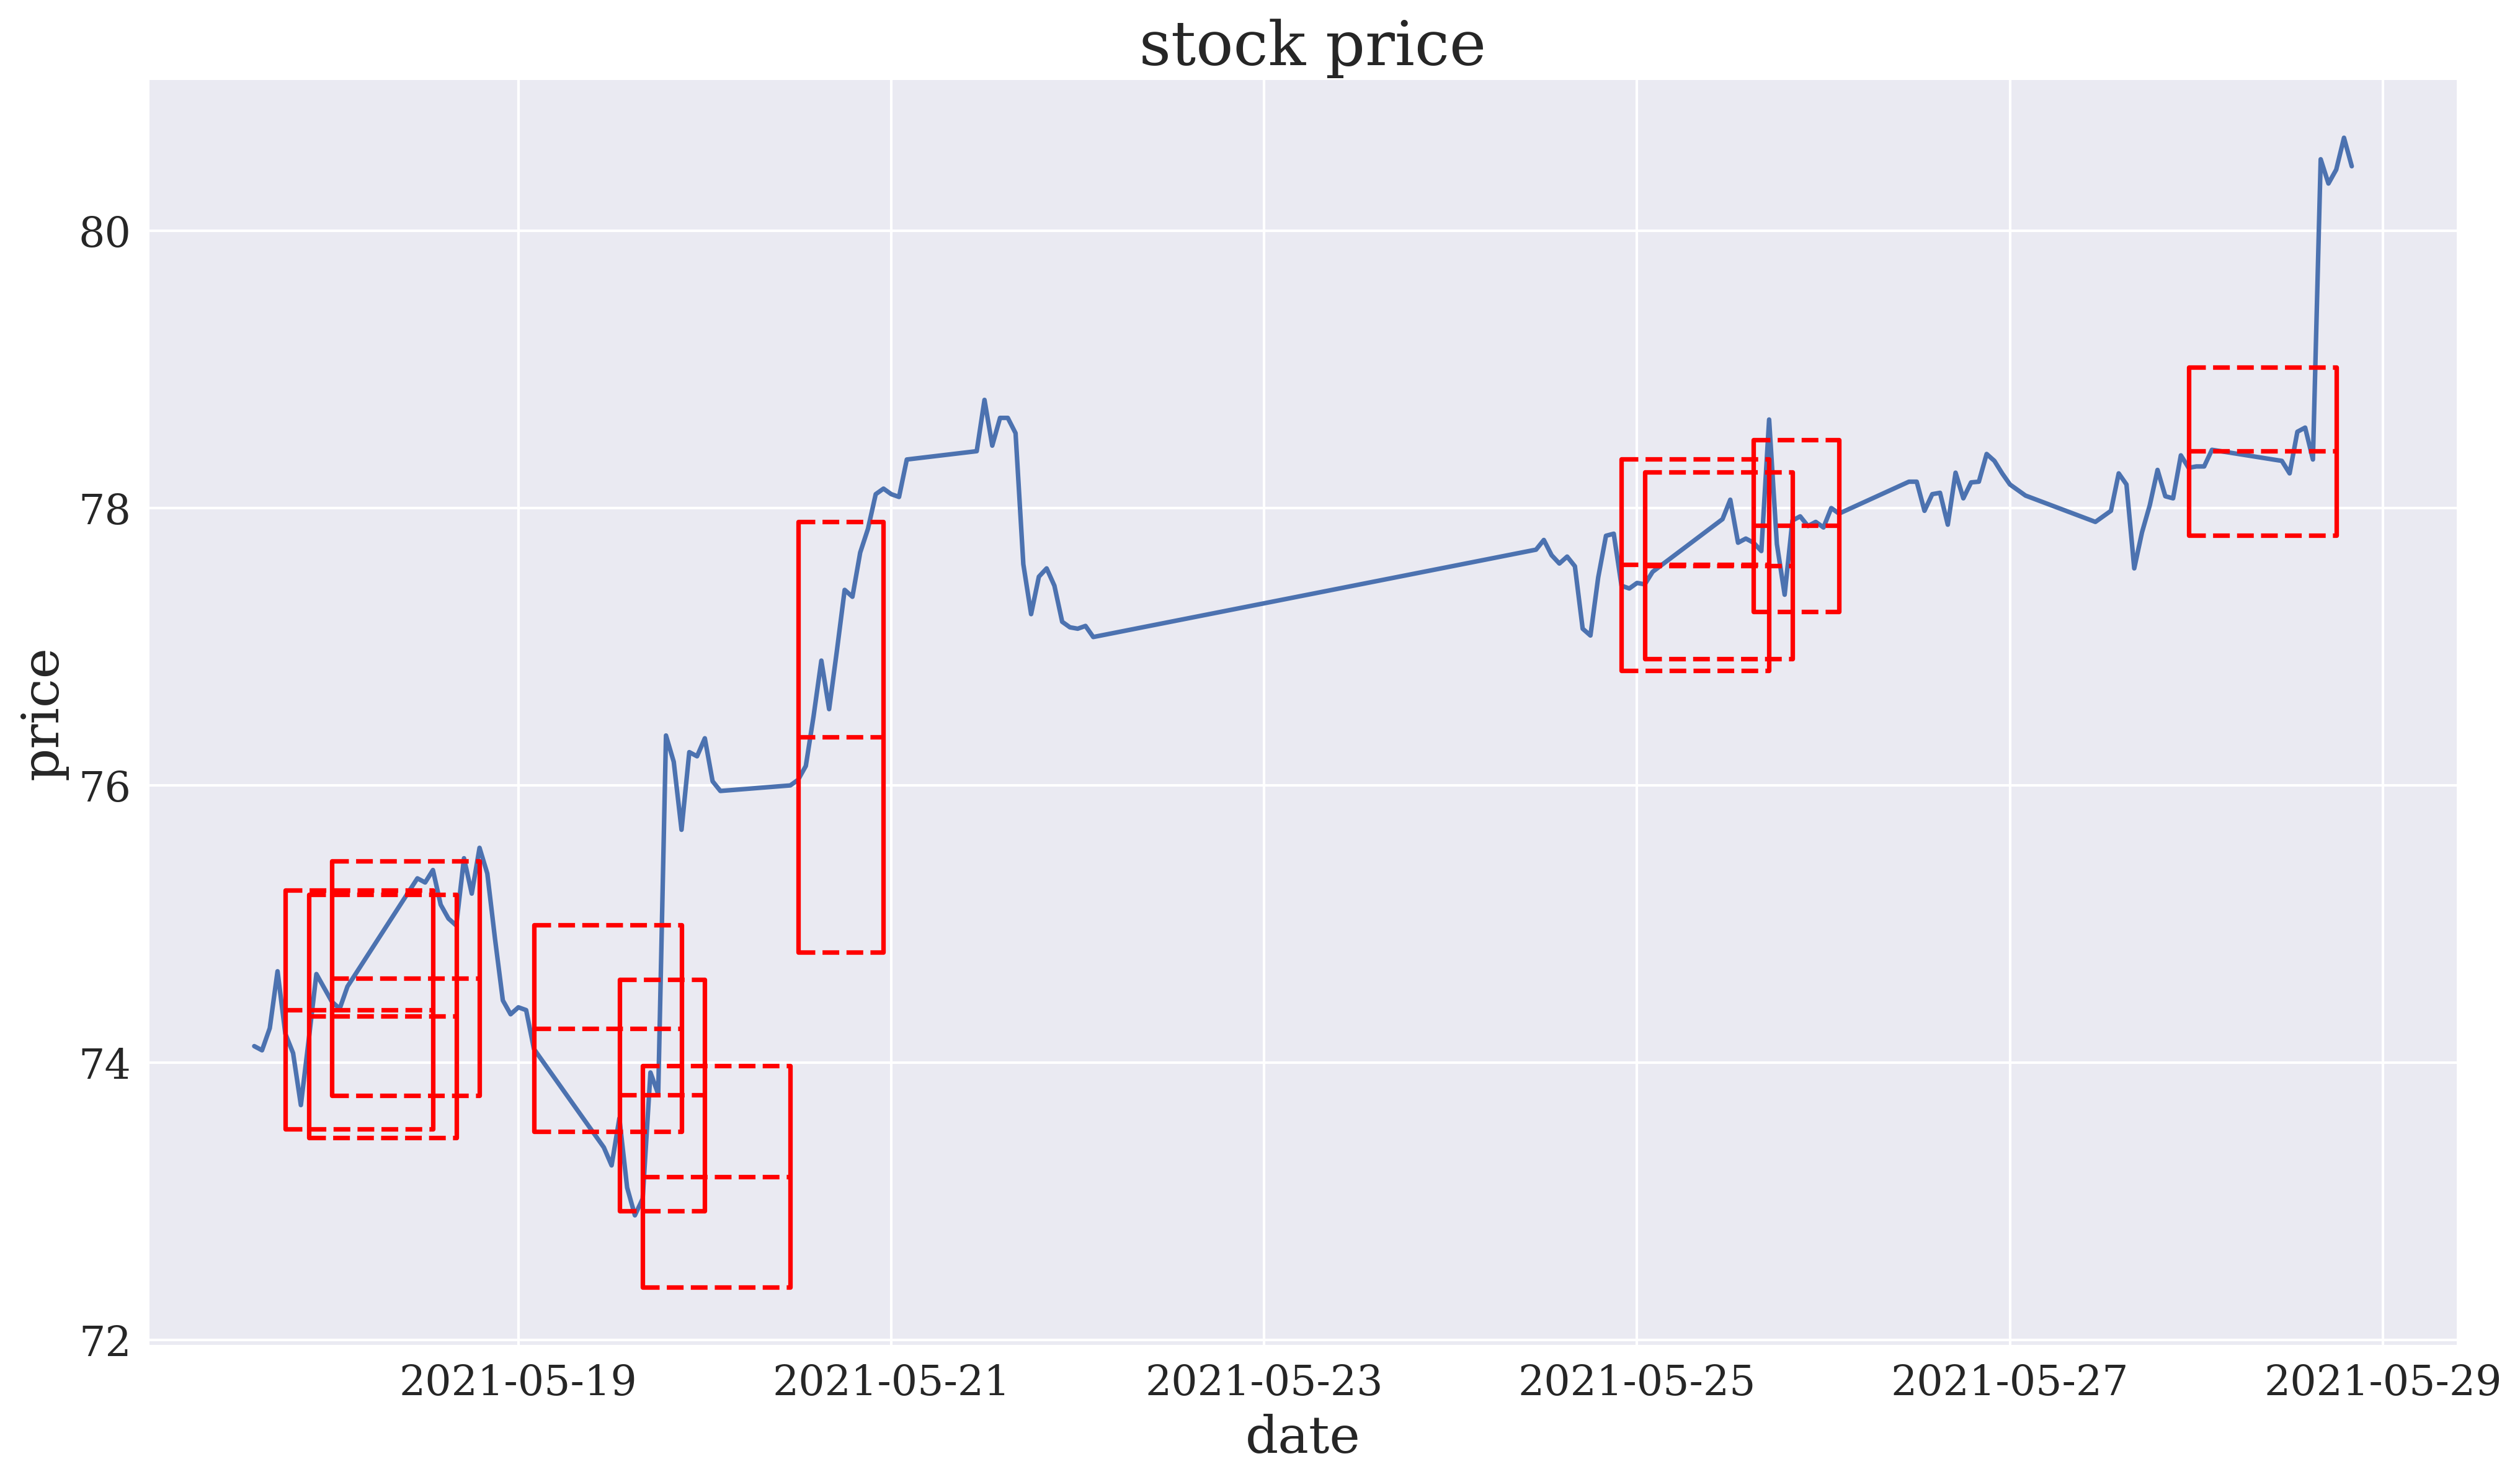

In [14]:
fig,ax = plt.subplots()
ax.set(title=' stock price', xlabel='date', ylabel='price')
ax.plot(barriers.price[-150:])
for i in barriers.index[-155::3]:
    barrier = barriers.loc[i]
    start = i
    end = barrier.vert_barrier
    if not pd.isnull(end) and barrier.out == 1:
        upper_barrier = barrier.top_barrier
        lower_barrier = barrier.bottom_barrier
        ax.plot([start, end], [upper_barrier, upper_barrier], 'r--');
        ax.plot([start, end], [lower_barrier, lower_barrier], 'r--');
        ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, (lower_barrier + upper_barrier)*0.5], 'r--');
        ax.plot([start, start], [lower_barrier, upper_barrier], 'r-');
        ax.plot([end, end], [lower_barrier, upper_barrier], 'r-');

In [15]:
def create_HLCV(i): 
    df = pd.DataFrame(index=data_stock.index)
    df[f'high_{i}'] = data_stock.high.rolling(i).max()
    df[f'low_{i}'] = data_stock.low.rolling(i).min()
    df[f'close_{i}'] = data_stock.close.rolling(i).\
                        apply(lambda x:x[-1]) 
    df[f'volume_{i}'] = data_stock.volume.rolling(i).sum()
    df[f'rsi_{i}'] = talib.RSI(data_stock['close']).rolling(i).mean()
    
    return df

In [16]:
def create_features(i):
    df = create_HLCV(i)
    high = df[f'high_{i}'] + 0.00001
    low = df[f'low_{i}']
    close = df[f'close_{i}']
    volume = df[f'volume_{i}']
    rsi = df[f'rsi_{i}']
    features = pd.DataFrame(index=data_stock.index)
    features[f'volume_{i}'] = volume
    features[f'price_spread_{i}'] = high - low
    features[f'close_loc_{i}'] = (high - close) / (high  - low)
    features[f'close_change_{i}'] = close.diff()
    features[f'rsi_{i}'] = rsi
        
    return features

In [17]:
def create_bunch_of_features():
    periods = [1,2,3,5,6,7,8,9,10,20,40,60]
    bunch_of_features = pd.DataFrame(index=data_stock.index)
    for period in periods:
        f = create_features(period)
        bunch_of_features = bunch_of_features.join(f)

    bunch_of_features['hour'] = data_stock.index.hour
    return bunch_of_features

bunch_of_features = create_bunch_of_features()
bunch_of_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33179 entries, 2012-01-03 15:00:00 to 2021-05-28 20:00:00
Data columns (total 61 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   volume_1         33179 non-null  float64
 1   price_spread_1   33179 non-null  float64
 2   close_loc_1      33179 non-null  float64
 3   close_change_1   33178 non-null  float64
 4   rsi_1            33165 non-null  float64
 5   volume_2         33178 non-null  float64
 6   price_spread_2   33178 non-null  float64
 7   close_loc_2      33178 non-null  float64
 8   close_change_2   33177 non-null  float64
 9   rsi_2            33164 non-null  float64
 10  volume_3         33177 non-null  float64
 11  price_spread_3   33177 non-null  float64
 12  close_loc_3      33177 non-null  float64
 13  close_change_3   33176 non-null  float64
 14  rsi_3            33163 non-null  float64
 15  volume_5         33175 non-null  float64
 16  price_spread_5   33175 

In [18]:
dropna_barriers = barriers.dropna()
data = bunch_of_features[60:-13].assign(out=dropna_barriers[58:-2].out)
data.dropna(inplace=True)
out = data.out
out=out.astype('int')
data.drop('out', axis=1, inplace=True)
data

,volume_1,price_spread_1,close_loc_1,close_change_1,rsi_1,volume_2,price_spread_2,close_loc_2,close_change_2,rsi_2,...,price_spread_40,close_loc_40,close_change_40,rsi_40,volume_60,price_spread_60,close_loc_60,close_change_60,rsi_60,hour
2012-01-11 17:00:00,1952248.0,0.14001,0.071495,0.130,70.903003,1956483.0,0.14001,0.071495,0.130,63.904476,...,0.44001,0.022749,0.130,58.506442,54007880.0,0.45001,0.022244,0.130,54.051188,17
2012-01-11 18:00:00,1915936.0,0.05501,0.545537,0.015,72.031801,3868184.0,0.17501,0.171476,0.015,71.467402,...,0.47501,0.063178,0.015,59.204060,54446694.0,0.48501,0.061875,0.015,54.527080,18
2012-01-11 19:00:00,1020687.0,0.04001,0.875031,-0.030,66.477168,2936623.0,0.06501,0.923089,-0.030,69.254484,...,0.47501,0.126334,-0.030,59.762812,54397812.0,0.48501,0.123729,-0.030,55.024704,19
2012-01-11 20:00:00,1490346.0,0.03001,0.666778,0.005,66.934820,2511033.0,0.04001,0.750062,0.005,66.705994,...,0.45501,0.120898,0.005,60.500128,55374813.0,0.48501,0.113420,0.005,55.393256,20
2012-01-11 21:00:00,1463244.0,0.06001,1.000000,-0.030,61.508954,2953590.0,0.06001,1.000000,-0.030,64.221887,...,0.45501,0.186831,-0.030,60.729253,56378633.0,0.48501,0.175275,-0.030,55.713479,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27 19:00:00,2982355.0,0.43851,0.144831,0.255,55.084361,7079889.0,0.57651,0.110163,0.255,52.685633,...,1.93351,0.256016,0.255,53.635960,125299753.0,1.97001,0.251273,0.255,52.649953,19
2021-05-27 20:00:00,2935501.0,0.35001,0.585726,-0.190,51.125453,5917856.0,0.43851,0.578117,-0.190,53.104907,...,1.93351,0.354283,-0.190,53.441313,127397121.0,1.97001,0.347719,-0.190,52.735724,20
2021-05-27 21:00:00,2752322.0,0.29001,0.206924,-0.015,50.814953,5687823.0,0.45001,0.488900,-0.015,50.970203,...,1.93351,0.362041,-0.015,53.181697,130130815.0,1.97001,0.355333,-0.015,52.818779,21
2021-05-27 22:00:00,6703471.0,0.70001,0.071442,0.310,56.671630,9455793.0,0.70001,0.071442,0.310,53.743292,...,1.93351,0.201711,0.310,53.247861,136821404.0,1.97001,0.197974,0.310,52.993247,22


In [19]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=20)

model.fit(data, out)

Learning rate set to 0.5
0:	learn: 1.0664537	total: 91ms	remaining: 1.73s
1:	learn: 1.0558910	total: 116ms	remaining: 1.04s
2:	learn: 1.0490578	total: 140ms	remaining: 792ms
3:	learn: 1.0435098	total: 162ms	remaining: 648ms
4:	learn: 1.0403836	total: 185ms	remaining: 554ms
5:	learn: 1.0375051	total: 210ms	remaining: 490ms
6:	learn: 1.0335399	total: 241ms	remaining: 448ms
7:	learn: 1.0307548	total: 269ms	remaining: 404ms
8:	learn: 1.0259183	total: 297ms	remaining: 363ms
9:	learn: 1.0233939	total: 321ms	remaining: 321ms
10:	learn: 1.0211722	total: 344ms	remaining: 282ms
11:	learn: 1.0186249	total: 365ms	remaining: 243ms
12:	learn: 1.0163388	total: 386ms	remaining: 208ms
13:	learn: 1.0149844	total: 408ms	remaining: 175ms
14:	learn: 1.0122711	total: 436ms	remaining: 145ms
15:	learn: 1.0093022	total: 463ms	remaining: 116ms
16:	learn: 1.0067035	total: 489ms	remaining: 86.2ms
17:	learn: 1.0038553	total: 513ms	remaining: 57ms
18:	learn: 1.0016998	total: 538ms	remaining: 28.3ms
19:	learn: 0.998

In [20]:
predictions = model.predict(bunch_of_features[-30:])

In [21]:
predictions

array([[ 0],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [-1],
       [ 0],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0]])

In [22]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample', criterion="entropy")
clf.fit(data, out)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       n_estimators=1000)

In [23]:
predictions2 = clf.predict(bunch_of_features.iloc[-30:])

In [24]:
predictions2

array([-1, -1, -1, -1, -1,  0,  0, -1, -1,  1,  0,  0,  0,  0,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [25]:
predictions2[-10]

1

In [26]:
new_barriers = barriers[-30:].assign(predictions_out1=predictions[:,0])
new_barriers = new_barriers.assign(predictions_out2=predictions2)
new_barriers

,days_passed,price,vert_barrier,top_barrier,bottom_barrier,out,predictions_out1,predictions_out2
2021-05-26 22:00:00,33148,78.34,2021-05-27 18:00:00,79.097772,77.834819,-1,0,-1
2021-05-26 23:00:00,33149,78.25,2021-05-27 19:00:00,78.982485,77.761677,-1,-1,-1
2021-05-27 00:00:00,33150,78.17,2021-05-27 20:00:00,78.876538,77.698975,-1,-1,-1
2021-05-27 01:00:00,33151,78.13,2021-05-27 21:00:00,78.808611,77.677593,-1,-1,-1
2021-05-27 02:00:00,33152,78.09,2021-05-27 22:00:00,78.741686,77.655543,-1,-1,-1
2021-05-27 11:00:00,33153,77.9,2021-05-27 23:00:00,78.543619,77.47092,0,-1,0
2021-05-27 13:00:00,33154,77.98,2021-05-28 00:00:00,78.602809,77.564794,0,-1,0
2021-05-27 14:00:00,33155,78.25,2021-05-28 01:00:00,78.892042,77.821972,-1,-1,-1
2021-05-27 15:00:00,33156,78.17,2021-05-28 02:00:00,78.79039,77.756407,-1,-1,-1
2021-05-27 16:00:00,33157,77.565,2021-05-28 11:00:00,78.342801,77.046466,1,-1,1


In [27]:
new_barriers.to_excel('/Users/germanignatovich/Desktop/work/Диплом/excel/%s.xlsx' % new_barriers.index[-1].strftime("%Y-%m-%d_%H:%M:%S"))

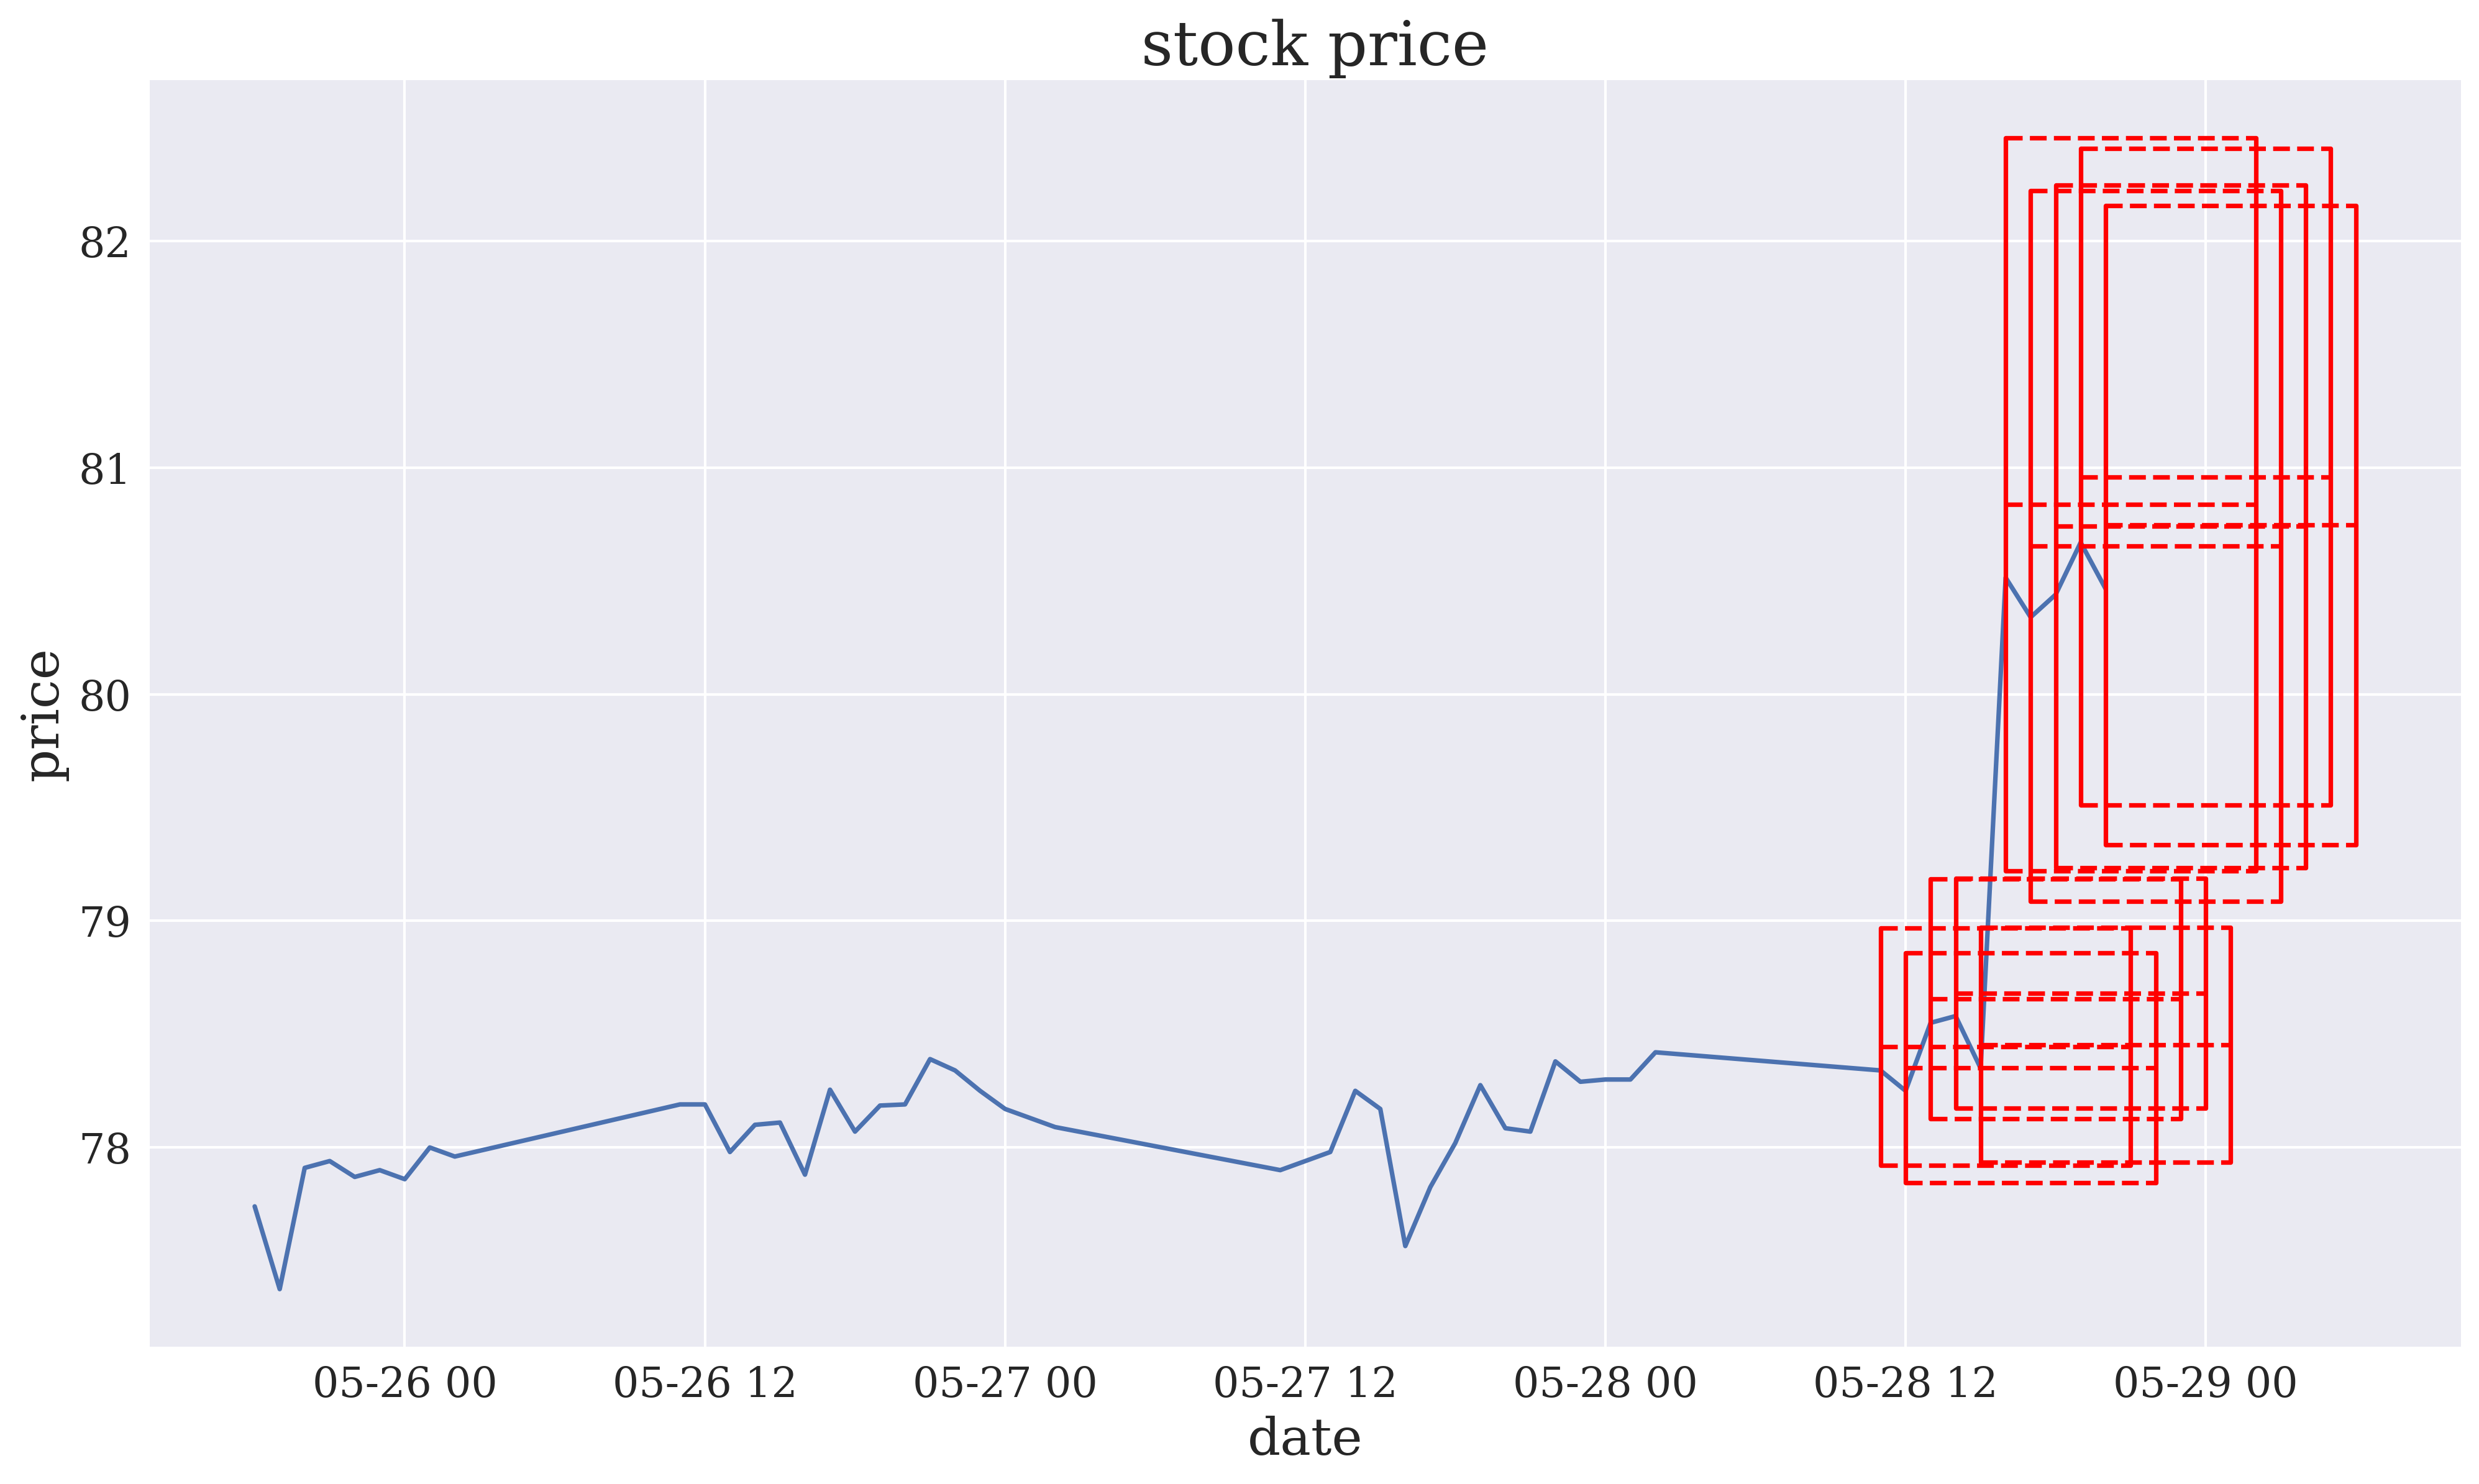

In [28]:
fig,ax = plt.subplots()
ax.set(title=' stock price', xlabel='date', ylabel='price')
ax.plot(barriers.price[-50:])
for i in barriers.index[-10:]:
    barrier = barriers.loc[i]
    start = i
    end = (datetime.strptime(i.strftime("%Y-%m-%d %H:%M:%S"), '%Y-%m-%d %H:%M:%S') + timedelta(hours = 10))
    upper_barrier = barrier.top_barrier
    lower_barrier = barrier.bottom_barrier
    ax.plot([start, end], [upper_barrier, upper_barrier], 'r--');
    ax.plot([start, end], [lower_barrier, lower_barrier], 'r--');
    ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, (lower_barrier + upper_barrier)*0.5], 'r--');
    ax.plot([start, start], [lower_barrier, upper_barrier], 'r-');
    ax.plot([end, end], [lower_barrier, upper_barrier], 'r-');

In [29]:
datetime.now().hour

22

In [30]:
data_stock.index.hour

Int64Index([15, 16, 17, 18, 19, 20, 21, 22, 23,  0,
            ...
            11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
           dtype='int64', length=33179)

In [31]:
data_stock.index = data_stock.index + timedelta(hours = 4)

In [32]:
data_stock

,volume,vw,open,close,high,low,number
2012-01-03 19:00:00,1100.0,5.5000,5.5000,5.5000,5.500,5.5000,6
2012-01-03 20:00:00,24951.0,5.5243,5.4800,5.5400,5.540,5.4800,29
2012-01-03 21:00:00,1359139.0,5.5509,5.4000,5.5500,5.590,5.4000,3115
2012-01-03 22:00:00,2822896.0,5.5226,5.5500,5.5200,5.580,5.4500,5652
2012-01-03 23:00:00,1179854.0,5.4913,5.5200,5.4900,5.525,5.4700,2604
...,...,...,...,...,...,...,...
2021-05-28 20:00:00,10183907.0,79.8321,78.3500,80.5150,80.750,78.2101,72113
2021-05-28 21:00:00,9467729.0,80.5845,80.5150,80.3400,81.090,80.1800,67594
2021-05-28 22:00:00,4874480.0,80.4138,80.3500,80.4401,80.665,80.2131,37518
2021-05-28 23:00:00,3332156.0,80.4729,80.4450,80.6700,80.745,80.2700,26669


In [33]:
(data_stock.high + 0.00001 - data_stock.low == 0).any()

False

In [34]:
talib.RSI(data_stock['close']).rolling(3).mean()

2012-01-03 19:00:00          NaN
2012-01-03 20:00:00          NaN
2012-01-03 21:00:00          NaN
2012-01-03 22:00:00          NaN
2012-01-03 23:00:00          NaN
                         ...    
2021-05-28 20:00:00    63.652381
2021-05-28 21:00:00    68.500560
2021-05-28 22:00:00    75.732962
2021-05-28 23:00:00    75.331638
2021-05-29 00:00:00    74.651625
Length: 33179, dtype: float64